## Industry

In order to optimise production costs, a steel mill needs to reduce energy consumption during the steel processing stage, and to do this, we needed to fit a model that would predict the temperature of the steel.

We were provided with several dataframes:

- `data_arc.csv` - electrode data;
- `data_bulk.csv` - data on the volume of bulk materials used;
- `data_gas.csv` - data on the volume of gas used;
- `data_temp.csv` - temperature measurement results;
- `data_wire.csv` - data on the volume of wire materials used.

In all dataframes the `key` column contains the lot number. There may be several rows in the files with the same `key` value: they correspond to different processing iterations.

As part of the solution to the task given, in addition to handling the data and training the model, a report had to be prepared for the customer representatives. This report is set out at the end of this notebook.

## Import of libraries

In [189]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
import warnings
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

## Data reading

In order to load the data correctly both on the local machine and on the server we will use `try-except` structure, in which we will handle `FileNotFoundError` exception. We will immediately parse the columns with dates to the required format.

In [190]:
try:
    data_arc = pd.read_csv('data_arc.csv', parse_dates=[1, 2])
except FileNotFoundError:
    data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv', parse_dates=[1, 2])

In [191]:
try:
    data_bulk = pd.read_csv('data_bulk.csv')
except FileNotFoundError:
    data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')

In [192]:
try:
    data_gas = pd.read_csv('data_gas.csv')
except FileNotFoundError:
    data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')

In [193]:
try:
    data_temp = pd.read_csv('data_temp.csv', parse_dates=[1])
except FileNotFoundError:
    data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv', parse_dates=[1])

In [194]:
try:
    data_wire = pd.read_csv('data_wire.csv')
except FileNotFoundError:
    data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')

## Exploratory data analysis

### Electrode data

In [195]:
data_arc.head(15)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494


Firslty, we will rename the columns by translating them into English and naming them in the style of `lower_case_with_underscores`.

In [196]:
data_arc.columns = ['key', 'arc_heating_start', 'arc_heating_finish', 'active_power', 'reactive_power']

In [197]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   key                 14876 non-null  int64         
 1   arc_heating_start   14876 non-null  datetime64[ns]
 2   arc_heating_finish  14876 non-null  datetime64[ns]
 3   active_power        14876 non-null  float64       
 4   reactive_power      14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


There are 5 columns in the dataframe `data_acr`, each containing 14,876 records, there are no gaps in the dataframe. The data format indicates that the dates have been converted correctly. Let's see how many unique records we have, and the time period we will work with.

In [198]:
print('The dataframe contains information about the processing of {} ladles of metal from {} to {}'
      .format(data_arc['key'].nunique(),
              data_arc['arc_heating_start'].min().date(), 
              data_arc['arc_heating_finish'].max().date()))

The dataframe contains information about the processing of 3214 ladles of metal from 2019-05-03 to 2019-09-01


In [199]:
data_arc.duplicated(keep=False).value_counts()

False    14876
dtype: int64

There are no duplicates in the dataframe.

In [200]:
data_arc.describe()

,key,active_power,reactive_power
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


The average value of the `active_power` column is to the right of the median, suggesting that the data is skewed and possibly outliers. We have a similar situation with the `reactive_power` column, except that there is also a negative value. Let's look at the total number of negative values in the dataframe.

In [201]:
data_arc.query('reactive_power < 0')

,key,arc_heating_start,arc_heating_finish,active_power,reactive_power
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


As expected, this entry is the only one, so it is definitely an outlier. The data for ladle 2116 should be deleted. We will create a list of ladles to delete, which we will fill in as we analyse the data. 

In [202]:
keys_to_delete = []
keys_to_delete.append(data_arc.query('reactive_power < 0')['key'].unique()[0])
keys_to_delete

[2116]

In [203]:
data_arc = data_arc.query('key not in @keys_to_delete')

Next, let's visualize the data by defining the function `hist_plotter`, which will take as its arguments the dataframe, the list of columns for which histograms are to be drawn. The range of values, the number of baskets, and the histogram type are set by default and can be changed when the function is called.

In [204]:
def hist_plotter(df, columns, values_range=(0, 5), bins=100, histtype='step'):
    plt.figure(figsize=(12, 9), dpi= 75)
    for i in range(len(columns)):
        plt.hist(df[columns[i]], bins=bins, label=columns[i], range=values_range, histtype=histtype)
    plt.legend(loc='upper left')
    plt.show()

Let's call the function for columns `active_power`, `reactive_power`. We will pass the `values_range` argument a tuple from -1 to the maximum value of `active_power` column (because its value is higher than `reactive_power`), rounded to the nearest next integer.

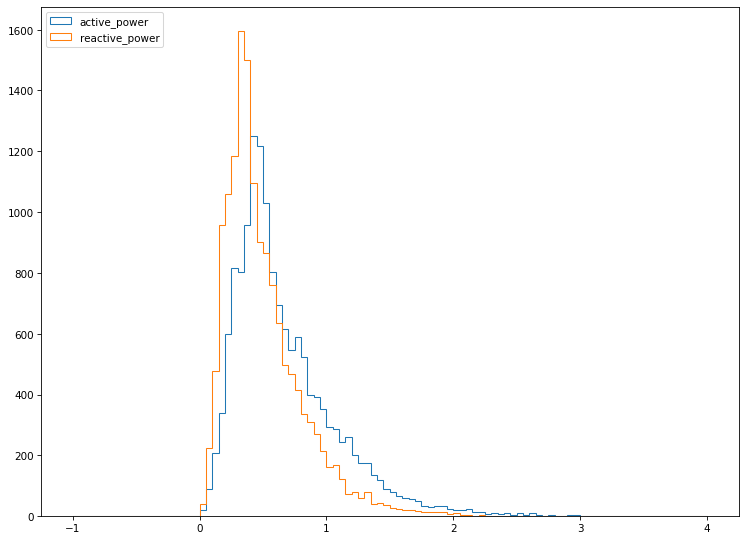

In [205]:
hist_plotter(data_arc, ['active_power', 'reactive_power'], 
        values_range=(-1, np.ceil(data_arc['active_power'].describe()['max'])))

As expected, the data in both columns is skewed to the right, stretching quite long tails. After a value of 2, there are considerably fewer entries. Next, let's look at the whisker box, for the plotting of which we will also use a function similar to the one previously defined for plotting histograms.

In [206]:
def box_plotter(df, columns, values_range=(0, 5)):
    bottom, top = values_range
    plt.figure(figsize=(12, 9), dpi=75)
    sns.boxplot(data=df[columns], palette='hls')
    plt.ylim(bottom, top)
    plt.show()

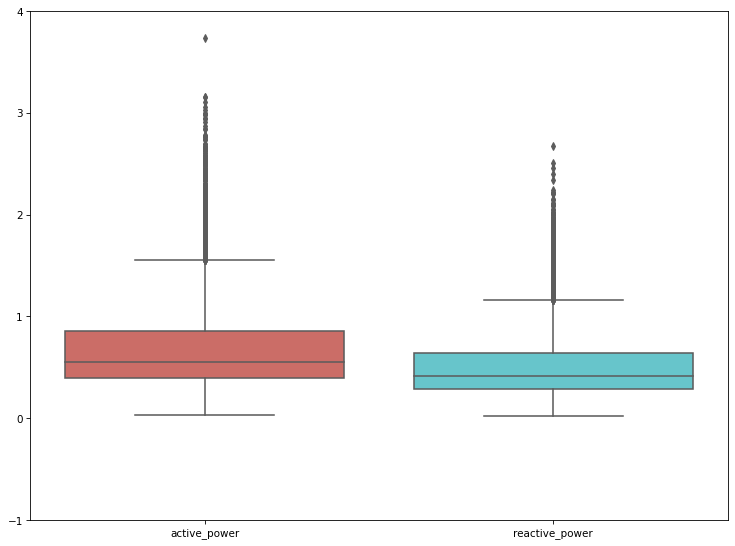

In [207]:
box_plotter(data_arc, ['active_power', 'reactive_power'], 
            values_range=(-1, np.ceil(data_arc['active_power'].describe()['max'])))

The graph shows quite a few outliers that would make sense to isolate and talk to the customer's representatives about their cause. We will remove only those values that stand out very strongly from the sequence of other outliers.

In [208]:
data_arc[(data_arc['active_power'] > 3.5) | 
         (data_arc['reactive_power'] == data_arc['reactive_power'].max())]

,key,arc_heating_start,arc_heating_finish,active_power,reactive_power
7799,1689,2019-07-02 18:49:03,2019-07-02 19:04:10,3.731596,2.676388


It is interesting to note that the maximum value of the `active_power` column corresponds to the maximum value of the `reactive_power` column, which may be due to the high correlation of these columns. Since we do not have a 100% understanding of whether the specified values are outliers, we will put the numbers of ladles with suspicious values in a separate list of suspicious ladles, which we will only remove from the training sample.

In [209]:
suspicious_keys = []
suspicious_keys.append(data_arc.query('active_power > 3.5')['key'].unique()[0])
suspicious_keys

[1689]

Let's look at the correlations between the columns by defining another function.

In [210]:
def heatmap_plotter(df, figure_size=(12, 9), dots_per_inch=75):
    plt.figure(figsize=figure_size, dpi=dots_per_inch)
    sns.heatmap(df.corr(), 
            xticklabels=df.corr().columns, 
            yticklabels=df.corr().columns, 
            cmap='RdYlGn', center=0, annot=True)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

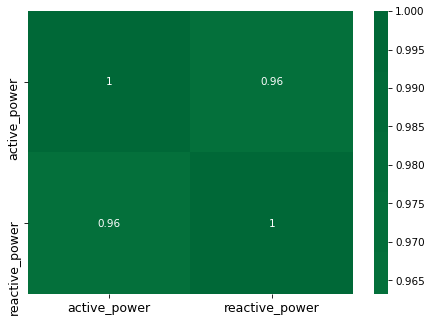

In [211]:
heatmap_plotter(data_arc.drop(labels='key', axis=1), figure_size=(7, 5))

Our assumption that there is a very high correlation between the `active_power' and `reactive_power' columns was confirmed.

In the future we will need to predict the temperature of the steel, so we need aggregate data for each of the ladles, so we create a new dataframe according to the "one line, one ladle" principle. Choose some aggregation functions to add features to our model.

In [212]:
data_arc_agg = data_arc.pivot_table(index='key', values=['active_power', 'reactive_power'],
                                    aggfunc=['sum', 'mean', 'count'])
data_arc_agg.reset_index(inplace=True)
data_arc_agg.head()

key          sum                        mean                       count  \
      active_power reactive_power active_power reactive_power active_power   
0   1     4.878147       3.183241     0.975629       0.636648            5   
1   2     3.052598       1.998112     0.763150       0.499528            4   
2   3     2.525882       1.599076     0.505176       0.319815            5   
3   4     3.209250       2.060298     0.802313       0.515074            4   
4   5     3.347173       2.252643     0.836793       0.563161            4   

                  
  reactive_power  
0              5  
1              4  
2              5  
3              4  
4              4

Let's rename the columns to get rid of the multi-indexes.

In [213]:
data_arc_agg.columns = ['key',
                        'active_power_sum', 'reactive_power_sum', 
                        'active_power_mean', 'reactive_power_mean',
                        'active_power_count', 'reactive_power_count']
data_arc_agg.head()

,key,active_power_sum,reactive_power_sum,active_power_mean,reactive_power_mean,active_power_count,reactive_power_count
0,1,4.878147,3.183241,0.975629,0.636648,5,5
1,2,3.052598,1.998112,0.763150,0.499528,4,4
2,3,2.525882,1.599076,0.505176,0.319815,5,5
3,4,3.209250,2.060298,0.802313,0.515074,4,4
4,5,3.347173,2.252643,0.836793,0.563161,4,4


The data_arc_agg dataframe is ready for further use.

### Data on the volume of bulk materials used

In [214]:
data_bulk.head(15)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


Rename the columns in the same way as in the previous subsection.

In [215]:
data_bulk.columns = ','.join(data_bulk.columns.to_list()).replace(' ', '_').lower().split(',')
data_bulk.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [216]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   252 non-null    float64
 2   bulk_2   22 non-null     float64
 3   bulk_3   1298 non-null   float64
 4   bulk_4   1014 non-null   float64
 5   bulk_5   77 non-null     float64
 6   bulk_6   576 non-null    float64
 7   bulk_7   25 non-null     float64
 8   bulk_8   1 non-null      float64
 9   bulk_9   19 non-null     float64
 10  bulk_10  176 non-null    float64
 11  bulk_11  177 non-null    float64
 12  bulk_12  2450 non-null   float64
 13  bulk_13  18 non-null     float64
 14  bulk_14  2806 non-null   float64
 15  bulk_15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


The dataframe `data_bulk` contains data of int and float types. The number of rows in the `key` column is slightly lower than in the previous dataframe, which may be due to the presence of ladles by which bulk materials were not added. A large number of omissions are also conspicuous, again indicating the use of some additives on rare occasions. Let's take a closer look at the gaps with a separate data set obtained with the following function.

In [217]:
def missing_values_table(df):
        # Number of missing values
        mis_val = df.isna().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isna().sum() / len(df)
        
        # Creating a dataframe
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Renaming the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing values', 1 : '% of total values'})
        
        # Filtering and sorting the resulting dataframe
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of total values', ascending=False).round(1)
        
        return mis_val_table_ren_columns

In [218]:
missing_values_table(data_bulk)

,Missing values,% of total values
bulk_8,3128,100.0
bulk_13,3111,99.4
bulk_9,3110,99.4
bulk_2,3107,99.3
bulk_7,3104,99.2
bulk_5,3052,97.5
bulk_10,2953,94.4
bulk_11,2952,94.3
bulk_1,2877,91.9
bulk_6,2553,81.6


It is notable that 9 out of 15 entries have more than 90% gaps (bulk_8 is 100%, but this may be due to rounding).

In [219]:
data_bulk.duplicated(keep=False).value_counts()

False    3129
dtype: int64

There are no duplicates in the dataframe.

In [220]:
data_bulk.describe()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


One of the most frequently used additives (bulk_12) is added on average almost in the largest amount - only bulk_7 is added more, but this has only happened 25 times. Bulk_8 was used only once. 

Let's look at the histograms, breaking down the data into subgroups to make the graph easier to read.

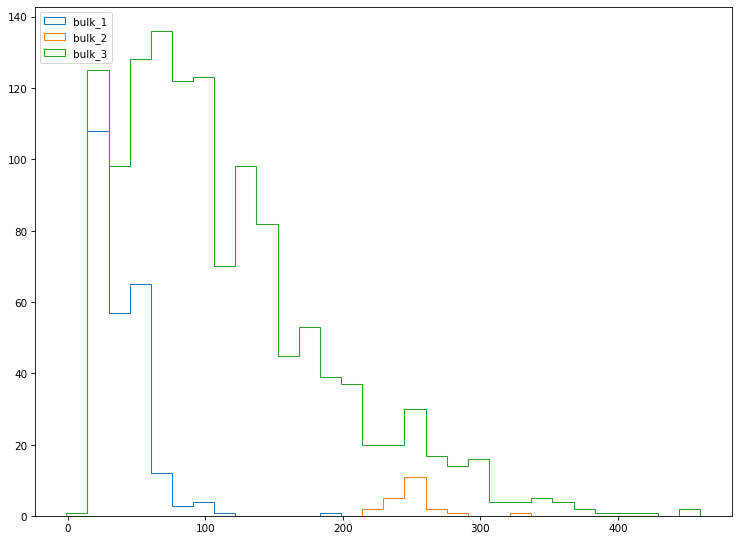

In [221]:
hist_plotter(data_bulk, data_bulk.columns.to_list()[1:4], bins=30, values_range=(-1, 460))

The data for columns bulk_1, bulk_2 and bulk_3 are not normally distributed, there are many peaks at different values, in addition, all the data are skewed to the right, there are outlier-like values, but they do not look critical.

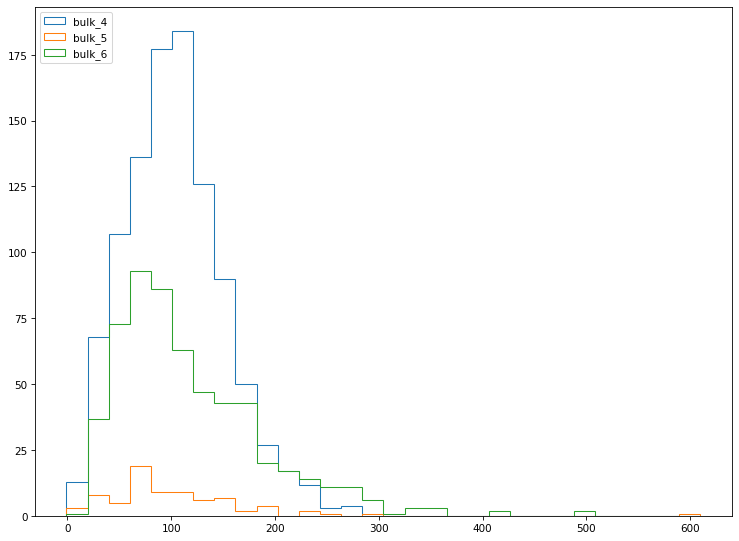

In [222]:
hist_plotter(data_bulk, data_bulk.columns.to_list()[4:7], bins=30, values_range=(-1, 610))

The distribution of data in columns bulk_4, bulk_5 and bulk_6 is slightly more normal than in the previous example, but there is also data skewness, as well as more obvious outliers, especially in column bulk_5.

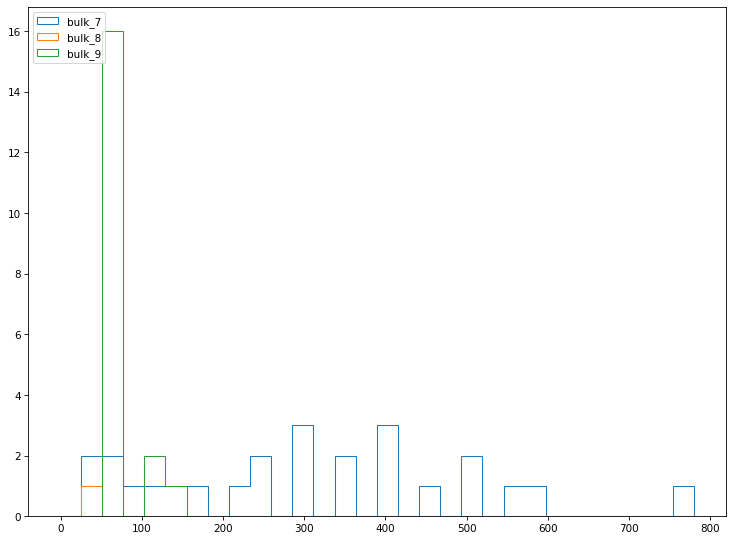

In [223]:
hist_plotter(data_bulk, data_bulk.columns.to_list()[7:10], bins=30, values_range=(-1, 780))

The data of columns bulk_8 and bulk_9 are concentrated in the range up to 150. The data of column bulk_7 are distributed up to a value of around 780, with a large number of gaps and approximately the same density over the entire range of values.  

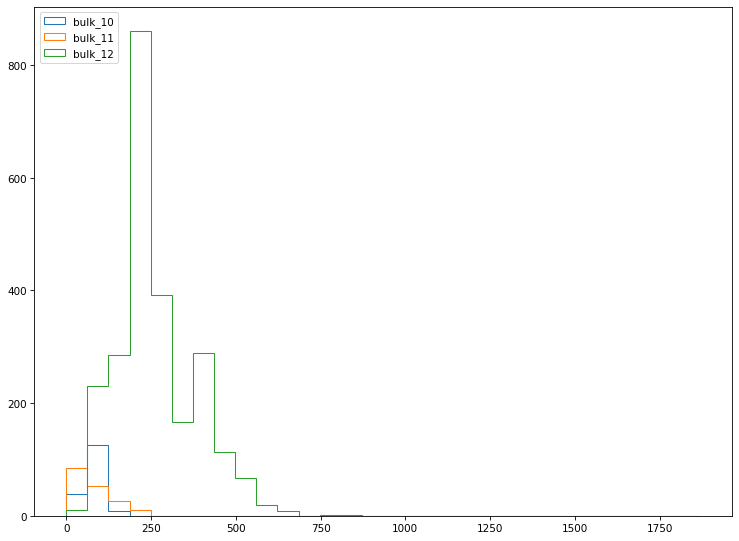

In [224]:
hist_plotter(data_bulk, data_bulk.columns.to_list()[10:13], bins=30, values_range=(-1, 1870))

The data in columns bulk_10, bulk_11 and bulk_12 look rather accurate. The second peak in the bulk_12 column is visible, as well as the slight skewness of this column. In addition, this column contains an outlier at the level of 1849, which is not even visible in the graph due to the values range limit. It is advisable to remove this ladle.

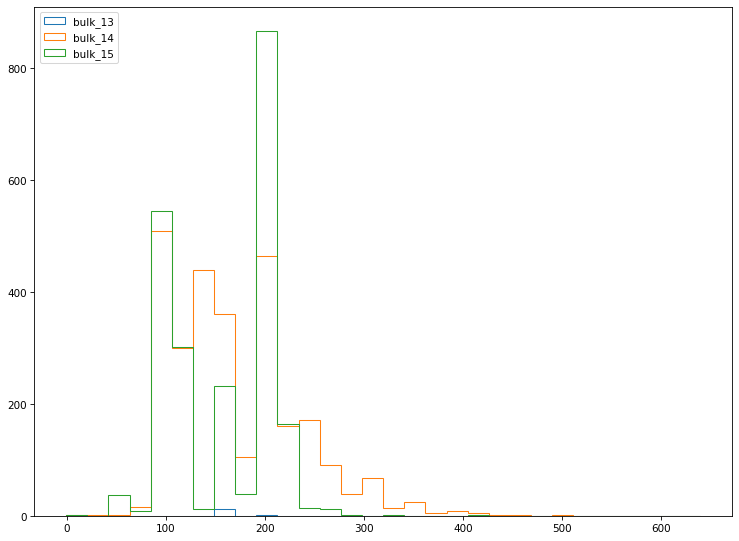

In [225]:
hist_plotter(data_bulk, data_bulk.columns.to_list()[13:], bins=30, values_range=(-1, 640))

Columns bulk_13, bulk_14 and bulk_15 are also in chaos. The column has an outlier-like value at 630, but it does not really stand out from the rest of the column, so let's not touch anything here for now.

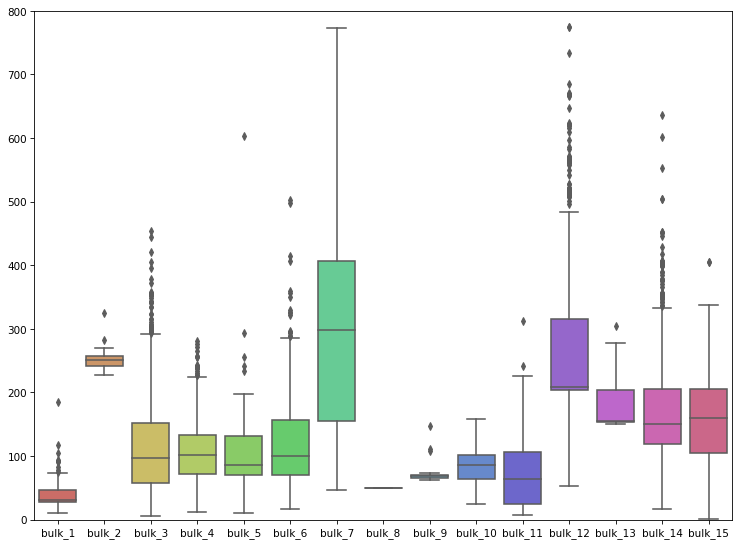

In [226]:
box_plotter(data_bulk, data_bulk.columns.to_list()[1:], 
            values_range=(-1, 800))

Let's put numbers of ladles with anomalous values in the list of suspicious ladles. Mark the outliers in columns bulk_5 and bulk_12 (the latter column does not show outliers due to values range limit). There are no outliers for bulk_7, in spite of the large interquartile range interval. This is due to the highest standard deviation of all the columns present in the data_bulk dataframe, which is quite clearly visible in both the histogram and the whisker box.

In [227]:
for i in data_bulk[(data_bulk['bulk_5'] > 500) | (data_bulk['bulk_12'] > 1800)]['key'].unique():
    suspicious_keys.append(i)
suspicious_keys

[1689, 322, 1808]

Let's fill in the remaining gaps with zeros, and then look for correlations between the additives.

In [228]:
data_bulk.fillna(0, inplace=True)

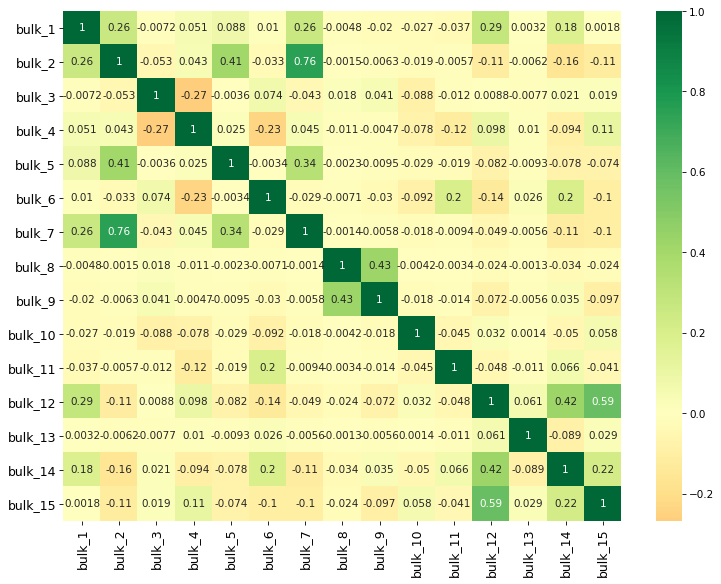

In [229]:
heatmap_plotter(data_bulk.drop(labels='key', axis=1))

Most often, bulk_2 and bulk_7, bulk_12 and bulk_15, bulk_8 and bulk_9 work together (but this is not very indicative due to rare use of both additives). The bulk_3 and bulk_4, bulk_4 and bulk_6 additives are least often used together.

### Data on the volume of wire materials used

In [230]:
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Rename the columns

In [231]:
data_wire.columns = ','.join(data_wire.columns.to_list()).replace(' ', '_').lower().split(',')
data_wire.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [232]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3055 non-null   float64
 2   wire_2  1079 non-null   float64
 3   wire_3  63 non-null     float64
 4   wire_4  14 non-null     float64
 5   wire_5  1 non-null      float64
 6   wire_6  73 non-null     float64
 7   wire_7  11 non-null     float64
 8   wire_8  19 non-null     float64
 9   wire_9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


For wire materials, the situation is similar to that previously described: some additives are used almost 100% of the time, but some are sporadic, probably due to the preparation of special grades of steel. 

In [233]:
missing_values_table(data_wire)

,Missing values,% of total values
wire_5,3080,100.0
wire_7,3070,99.6
wire_4,3067,99.5
wire_8,3062,99.4
wire_9,3052,99.1
wire_3,3018,98.0
wire_6,3008,97.6
wire_2,2002,65.0
wire_1,26,0.8


100% of the omissions in the wire_5 column are due to rounding, but the difference between the frequency of additive use is really enormous.

In [234]:
data_wire.duplicated(keep=False).value_counts()

False    3081
dtype: int64

There are no duplicates in the dataframe.

In [235]:
data_wire.describe()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


At first look, the data do not contain any abnormal values. All the columns show some skewness, mostly to the right. Let's look at the histograms.

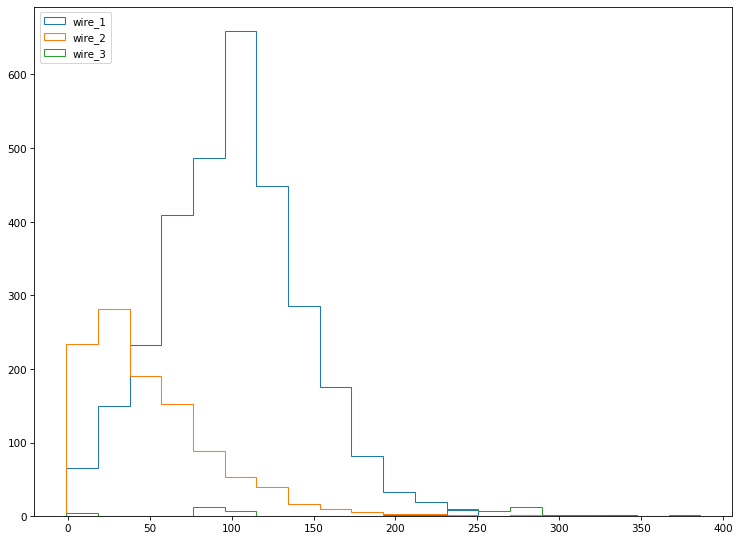

In [236]:
hist_plotter(data_wire, data_wire.columns.to_list()[1:4], bins=20, 
             values_range=(-1, np.ceil(data_wire['wire_3'].describe()['max'])))

Wire_1 and wire_2 have long tails to the right, which was also seen in the previously examined table. Wire_3 has a chaotic distribution with large gaps and about the same density in each section of the histogram. There are also a few outliers visible in the histogram, but these are better studied in the whisker box.

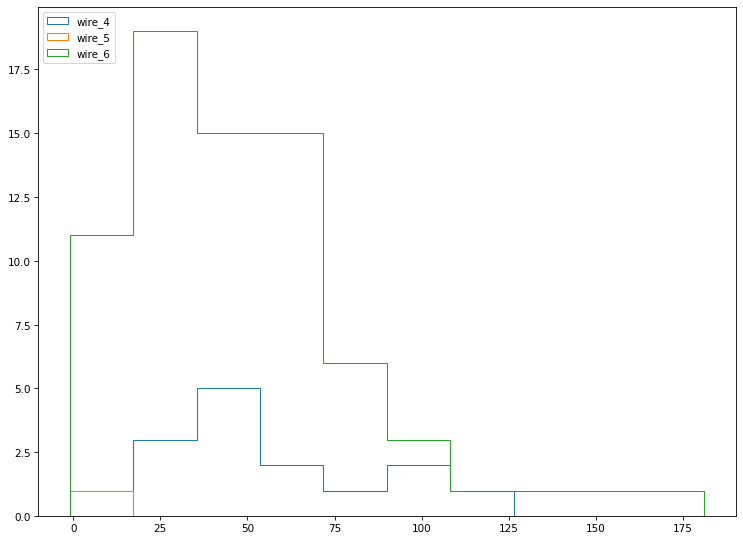

In [237]:
hist_plotter(data_wire, data_wire.columns.to_list()[4:7], bins=10, 
             values_range=(-1, np.ceil(data_wire['wire_6'].describe()['max'])))

Wire_4, wire_5 and wire_6 also have no normal distribution. wire_6 has a clear rightward skew, wire_4 has a second peak in addition to the tail. wire_5 is represented 1 time in the dataframe.

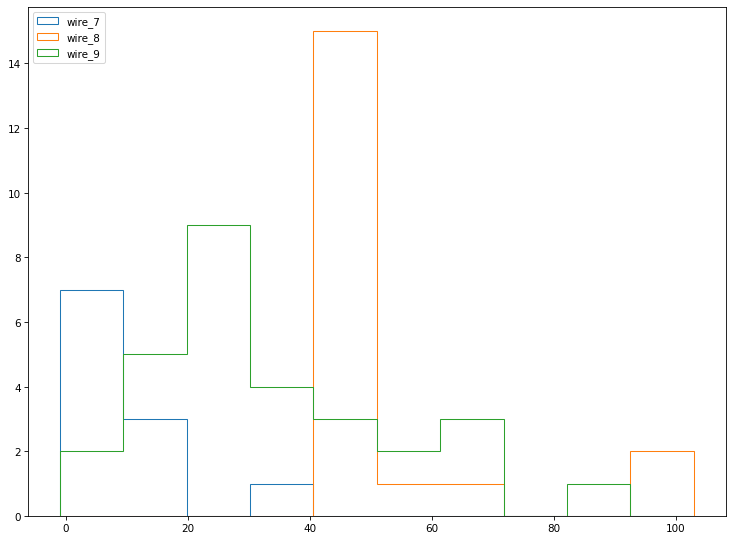

In [238]:
hist_plotter(data_wire, data_wire.columns.to_list()[7:10], bins=10, 
             values_range=(-1, np.ceil(data_wire['wire_8'].describe()['max'])))

The situation here is similar to that described above. In general, this is due to the small number of entries in all columns except wire_1 and wire_2

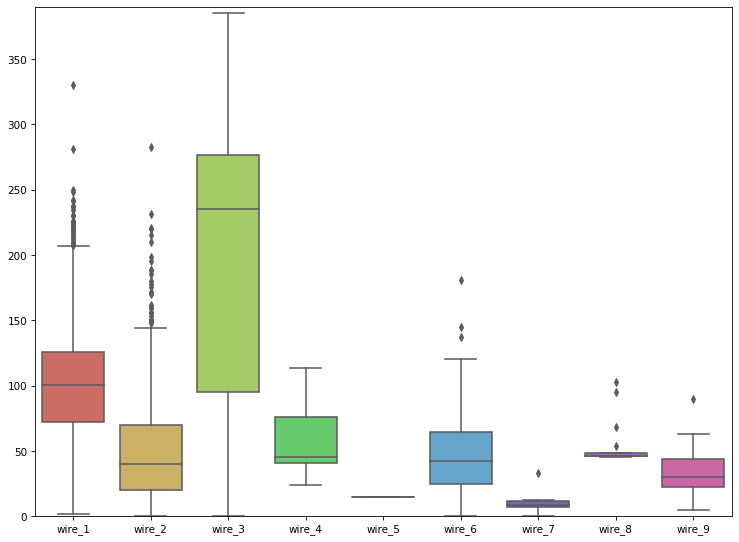

In [239]:
box_plotter(data_wire, data_wire.columns.to_list()[1:], values_range=(0, 390))

Wire_3 has the largest standard deviation, so all values fall within the interquartile range. Сolumns wire_1 and wire_2, which have the most records, contain 3 strong outliers. It seems better to mark them as suspicious.

In [240]:
data_wire[(data_wire['wire_1'] > 270) | (data_wire['wire_2'] > 270)]

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
1201,1269,142.365600,282.780152,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1392,1464,280.987214,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1732,1821,330.314424,69.337838,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [241]:
for i in data_wire[(data_wire['wire_1'] > 270) | (data_wire['wire_2'] > 270)]['key'].unique():
    suspicious_keys.append(i)
suspicious_keys

[1689, 322, 1808, 1269, 1464, 1821]

In [242]:
data_wire.fillna(0, inplace=True)
data_wire

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3077,3238,56.128799,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3078,3239,143.357761,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3079,3240,34.070400,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


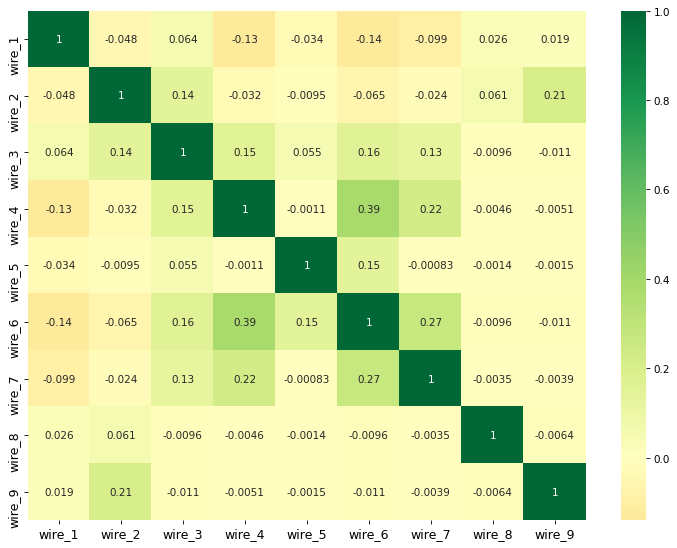

In [243]:
heatmap_plotter(data_wire.drop(labels='key', axis=1))

The use of any of the most frequently used wire additives has no effect on the use of the other additive, the correlation between them is -0.048. The highest correlation is observed between wire_4 and wire_6, wire_6 and wire_7, but the frequency of use of these additives is very low.

### Data on the volume of gas used

In [244]:
data_gas.head(15)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


Firstly, we will rename the columns.

In [245]:
data_gas.columns = ['key', 'gas_volume']

In [246]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   key         3239 non-null   int64  
 1   gas_volume  3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [247]:
data_gas.duplicated(keep=False).value_counts()

False    3239
dtype: int64

There are no duplicates in the dataframe.

In [248]:
data_gas.describe()

,key,gas_volume
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


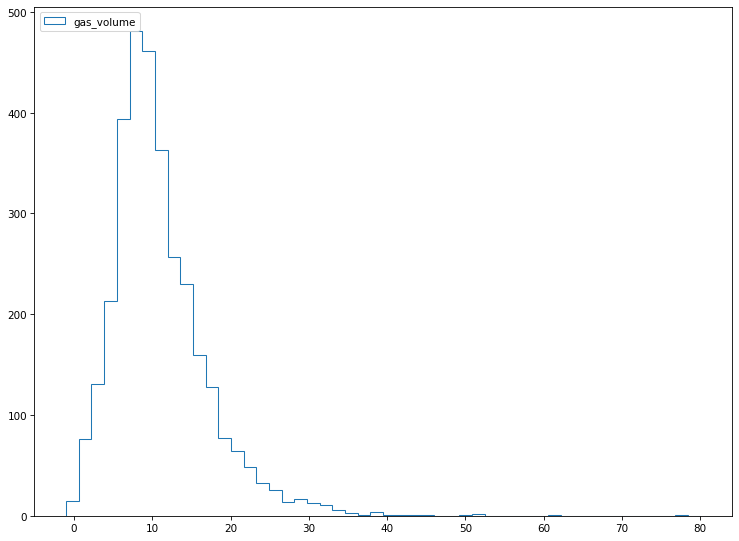

In [249]:
hist_plotter(data_gas, ['gas_volume'], bins=50, values_range=(-1, 80))

The histogram shows a skew of the data to the right with several individual outliers after the value of 60.

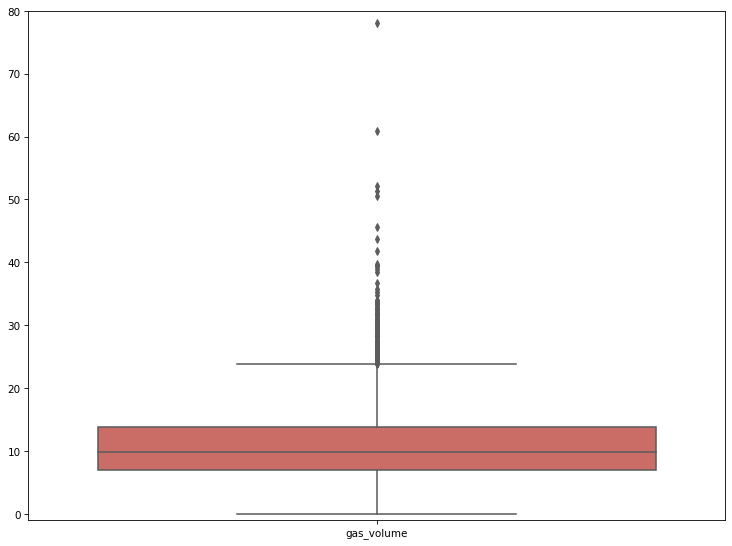

In [250]:
box_plotter(data_gas, ['gas_volume'], values_range=(-1, 80))

There are quite a few outliers visible, but they are mostly concentrated in one large group. It seems appropriate to mark the two ladles that stand out the most from the overall mass as suspicious.

In [251]:
for i in data_gas[(data_gas['gas_volume'] > 57)]['key'].unique():
    suspicious_keys.append(i)
suspicious_keys

[1689, 322, 1808, 1269, 1464, 1821, 280, 322]

### Temperature measurement results

We set to work on the dataframe containing the target feature.

In [252]:
data_temp.head(15)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


In [253]:
data_temp.columns = ['key', 'measuring_time', 'temperature']

In [254]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   key             15907 non-null  int64         
 1   measuring_time  15907 non-null  datetime64[ns]
 2   temperature     13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB


We can see that the dataframe contains 15907 rows, the column with the date is of the right type. In the `temperature` column we see almost 3000 omissions which need to be processed. 

In [255]:
data_temp.duplicated(keep=False).value_counts()

False    15907
dtype: int64

There are no duplicates in the dataframe.

In [256]:
data_temp.describe()

,key,temperature
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


From the above table, we can conclude that the dataframe contains entries with a steel temperature of about 1200 degrees Celsius. The dataframe contains entries for molten steel with a melting point of about 1500 degrees Celsius, values below this appear to be physically unreliable.

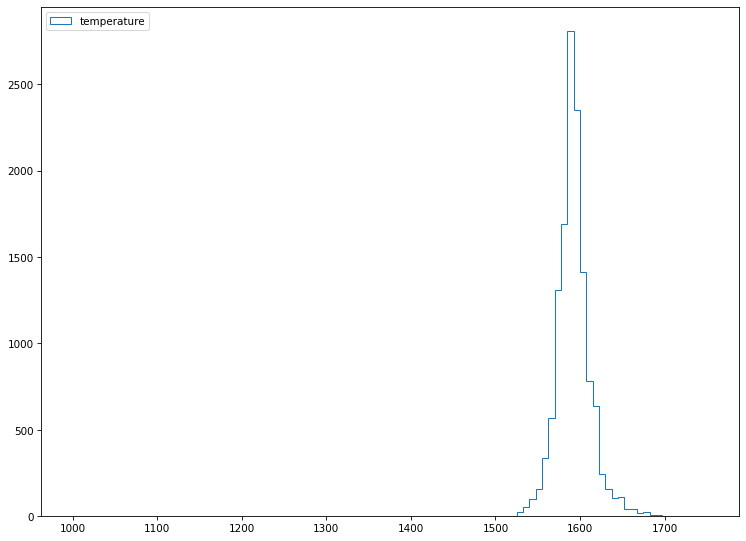

In [257]:
hist_plotter(data_temp,['temperature'], values_range=(1000, 1750))

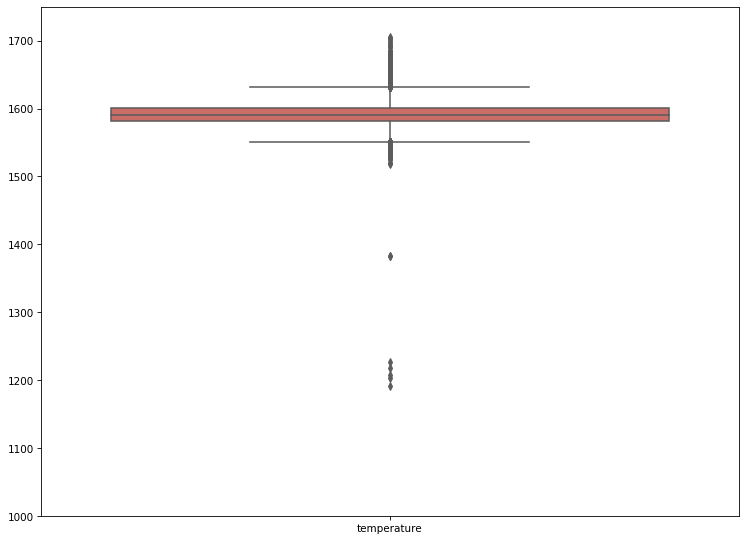

In [258]:
box_plotter(data_temp,['temperature'], values_range=(1000, 1750))

There aren't many ladles whose temperature doesn't look completely reliable from a physical point of view. It is better to get rid of them.

In [259]:
for i in data_temp[(data_temp['temperature'] < 1500)]['key'].unique():
    keys_to_delete.append(i)
keys_to_delete

[2116, 867, 1214, 1619, 1818, 2052, 2561]

The target feature for our model will be the final temperature of the ladle, the initial temperature of the ladle will be used as a feature, so the data must be processed as follows:
- delete ladles that have only one temperature measurement record;
- delete ladles with equal initial and final temperatures;
- remove ladles with missing initial or final temperatures.

Let's start with the first point.

In [260]:
data_temp_pivot = data_temp.pivot_table(index=['key'], values=['measuring_time'], aggfunc='count')
data_temp_pivot.sort_values(by='measuring_time')

,measuring_time
key,
279,1
195,1
2497,2
151,2
1415,2
...,...
2108,15
1214,16
44,16


There are only two ladles in the dataframe for which one measurement was recorded.

In [261]:
for i in data_temp_pivot.query('measuring_time == 1').index.to_list():
    keys_to_delete.append(i)
keys_to_delete

[2116, 867, 1214, 1619, 1818, 2052, 2561, 195, 279]

To achieve the result for the second and third points, we will need to create a new dataframe that contains the initial and final steel temperatures. To do this, firstly, we will get rid of the records for the ladles that had been previously selected for this purpose.

In [262]:
indices_to_delete = data_temp.query('key in @keys_to_delete').index.to_list()
data_temp = data_temp.drop(indices_to_delete).reset_index(drop=True)
data_temp.head()

,key,measuring_time,temperature
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


In [263]:
indices_to_delete = data_temp.query('key in @keys_to_delete').index.to_list()
indices_to_delete

[]

The records for the ladles containing the obvious outliers are deleted, we can make a new dataframe. We will create a filter in which we sort the data by ladle and time of measurement, so that the chronology is not broken, call the `duplicated()` method with argument `keep='first'` for the `key` column. This part of the filter will create a boolean array in which the row with the original temperature for each ladle will be marked as `False`. We then invert this array by comparing it to `True` using the inequality operator. Use the resulting boolean array to select the required values for the new dataframe.

In [264]:
start_filter = data_temp.sort_values(by=['key', 'measuring_time'])['key'].duplicated(keep='first') != True
data_temp_start = data_temp[start_filter]
data_temp_start.columns = ['key', 'measuring_time', 'initial_temperature']
data_temp_start

,key,measuring_time,initial_temperature
0,1,2019-05-03 11:16:18,1571.0
5,2,2019-05-03 11:37:27,1581.0
11,3,2019-05-03 12:13:17,1596.0
16,4,2019-05-03 12:52:57,1601.0
19,5,2019-05-03 13:23:19,1576.0
...,...,...,...
15822,3237,2019-08-31 22:44:04,1569.0
15827,3238,2019-08-31 23:30:31,1584.0
15830,3239,2019-09-01 01:31:47,1598.0
15838,3240,2019-09-01 02:39:01,1617.0


Let's make a similar dataframe for the final temperature by changing the `keep='first'` parameter in the filter to `keep='last'` in the `duplicated()` method.

In [265]:
end_filter = data_temp.sort_values(by=['key', 'measuring_time'])['key'].duplicated(keep='last') != True
data_temp_end = data_temp[end_filter]
data_temp_end.columns = ['key', 'measuring_time', 'final_temperature']
data_temp_end

,key,measuring_time,final_temperature
4,1,2019-05-03 11:30:39,1613.0
10,2,2019-05-03 11:59:12,1602.0
15,3,2019-05-03 12:34:57,1599.0
18,4,2019-05-03 12:59:25,1625.0
20,5,2019-05-03 13:36:01,1602.0
...,...,...,...
15826,3237,2019-08-31 23:05:43,NaN
15829,3238,2019-08-31 23:43:00,NaN
15837,3239,2019-09-01 02:24:15,NaN
15845,3240,2019-09-01 03:35:16,NaN


Create a table that contains the ladle number, the initial temperature and the final temperature of the steel.

In [266]:
data_temp_merged = data_temp_start.merge(data_temp_end, left_on='key', right_on='key', how='outer')
data_temp_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3207 entries, 0 to 3206
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   key                  3207 non-null   int64         
 1   measuring_time_x     3207 non-null   datetime64[ns]
 2   initial_temperature  3207 non-null   float64       
 3   measuring_time_y     3207 non-null   datetime64[ns]
 4   final_temperature    2469 non-null   float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 150.3 KB


In the `final_temperature` column we have many missing values. Since this is the target feature, we will have to remove the ladles with gaps. There are no missing values in the `initial_temperature` column.

In [267]:
data_temp_merged.dropna(inplace=True)
data_temp_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2469 entries, 0 to 2468
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   key                  2469 non-null   int64         
 1   measuring_time_x     2469 non-null   datetime64[ns]
 2   initial_temperature  2469 non-null   float64       
 3   measuring_time_y     2469 non-null   datetime64[ns]
 4   final_temperature    2469 non-null   float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 115.7 KB


Next, find the entries in which the initial and final temperatures are equal.

In [268]:
data_temp_merged['to_delete'] = data_temp_merged['initial_temperature'] == data_temp_merged['final_temperature']
data_temp_merged['to_delete'].value_counts()

False    2427
True       42
Name: to_delete, dtype: int64

There are several entries with the same initial and final temperatures, let's delete them.

In [269]:
data_temp_merged = data_temp_merged[data_temp_merged['to_delete'] == False]

Next, it is reasonable to delete the `to_delete` column, as well as the columns with dates of measurements. Let's try to extract some useful features from them before deleting, such as the number of seconds between the first and last temperature measurements.

In [270]:
data_temp_merged['time_diff'] = data_temp_merged['measuring_time_y'] - data_temp_merged['measuring_time_x']
data_temp_merged['time_diff'] = data_temp_merged['time_diff'].astype('timedelta64[s]').astype('int')
data_temp_merged

,key,measuring_time_x,initial_temperature,measuring_time_y,final_temperature,to_delete,time_diff
0,1,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0,False,861
1,2,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0,False,1305
2,3,2019-05-03 12:13:17,1596.0,2019-05-03 12:34:57,1599.0,False,1300
3,4,2019-05-03 12:52:57,1601.0,2019-05-03 12:59:25,1625.0,False,388
4,5,2019-05-03 13:23:19,1576.0,2019-05-03 13:36:01,1602.0,False,762
...,...,...,...,...,...,...,...
2464,2495,2019-08-06 00:35:45,1570.0,2019-08-06 00:54:42,1591.0,False,1137
2465,2496,2019-08-06 01:02:54,1554.0,2019-08-06 01:29:52,1591.0,False,1618
2466,2497,2019-08-06 01:41:53,1571.0,2019-08-06 01:53:50,1589.0,False,717
2467,2498,2019-08-06 02:03:49,1591.0,2019-08-06 02:25:31,1594.0,False,1302


We will now remove the unnecessary columns.

In [271]:
data_temp_merged.drop(['to_delete', 'measuring_time_x', 'measuring_time_y'], axis=1, inplace=True)
data_temp_merged

,key,initial_temperature,final_temperature,time_diff
0,1,1571.0,1613.0,861
1,2,1581.0,1602.0,1305
2,3,1596.0,1599.0,1300
3,4,1601.0,1625.0,388
4,5,1576.0,1602.0,762
...,...,...,...,...
2464,2495,1570.0,1591.0,1137
2465,2496,1554.0,1591.0,1618
2466,2497,1571.0,1589.0,717
2467,2498,1591.0,1594.0,1302


The dataframe with the target feature is ready to be merged.

### Merging of dataframes

Consistently merge all the dataframes into one, using the `key` column. The merge will be of the `inner` type, so that the final dataframe does not contain data on ladles that are not in the dataframe with the target feature.

In [272]:
merged_data = data_temp_merged.merge(data_arc_agg, left_on='key', right_on='key', how='inner')

In [273]:
merged_data = merged_data.merge(data_bulk, left_on='key', right_on='key', how='inner')

In [274]:
merged_data = merged_data.merge(data_wire, left_on='key', right_on='key', how='inner')

In [275]:
merged_data = merged_data.merge(data_gas, left_on='key', right_on='key', how='inner')

In [277]:
merged_data.nunique()

key                     2288
initial_temperature      133
final_temperature         75
time_diff               1561
active_power_sum        2288
reactive_power_sum      2288
active_power_mean       2288
reactive_power_mean     2288
active_power_count        15
reactive_power_count      15
bulk_1                    38
bulk_2                    13
bulk_3                   264
bulk_4                   199
bulk_5                    43
bulk_6                   187
bulk_7                    14
bulk_8                     2
bulk_9                    10
bulk_10                   70
bulk_11                   82
bulk_12                  301
bulk_13                   11
bulk_14                  254
bulk_15                  143
wire_1                  1786
wire_2                   558
wire_3                    35
wire_4                    13
wire_5                     1
wire_6                    43
wire_7                     5
wire_8                    10
wire_9                    22
gas_volume    

In total we have 2288 records instead of 2427, which is due to the absence of some of the ladles from the main datatrame in the remaining dataframes. Also in the final dataframe we have a column wire_5 with a single value.

In [278]:
merged_data['wire_5'].unique()

array([0.])

It is a good idea to delete this column, as it will not help in the training of the model.

In [279]:
missing_values_table(merged_data)

,Missing values,% of total values


There are no missing values in the dataframe. Let's look at the correlations of the target feature with the features.

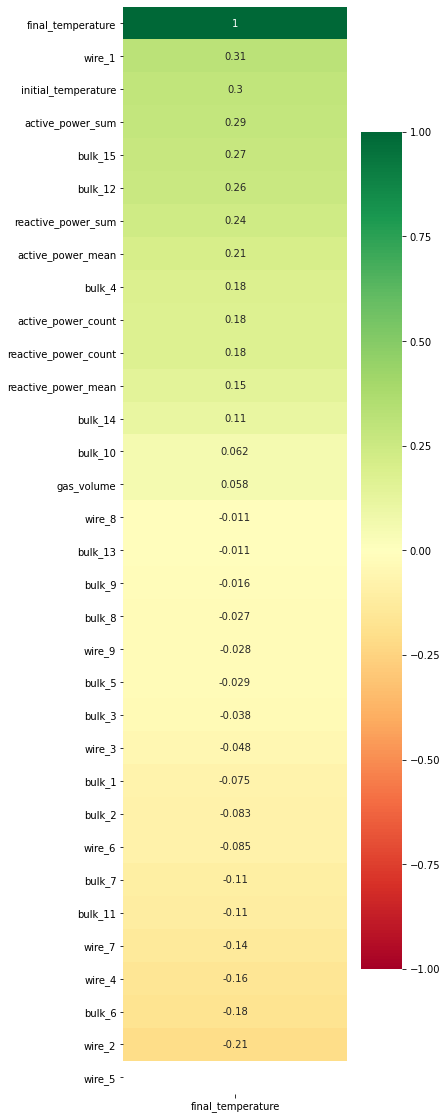

In [281]:
plt.figure(figsize=(5, 20))
sns.heatmap(merged_data.drop(['time_diff', 'key'], axis=1).corr()[['final_temperature']].sort_values(by='final_temperature', 
                  ascending=False), vmin=-1, vmax=1, annot=True, cmap='RdYlGn')
None

The strongest positive correlations in the range of 0.26 to 0.31 for the target feature with initial temperature and sum of energy, and with the additives wire_1, bulk_12 and bulk_15. The strongest negative correlations were found with additives wire_2, wire_4 and bulk_6, but these ranged from -0.16 to -0.21. The positive correlations can be interpreted as weak and the negative correlations as very weak. No strong correlations are detected.

Let's look at the correlations of the features with each other.

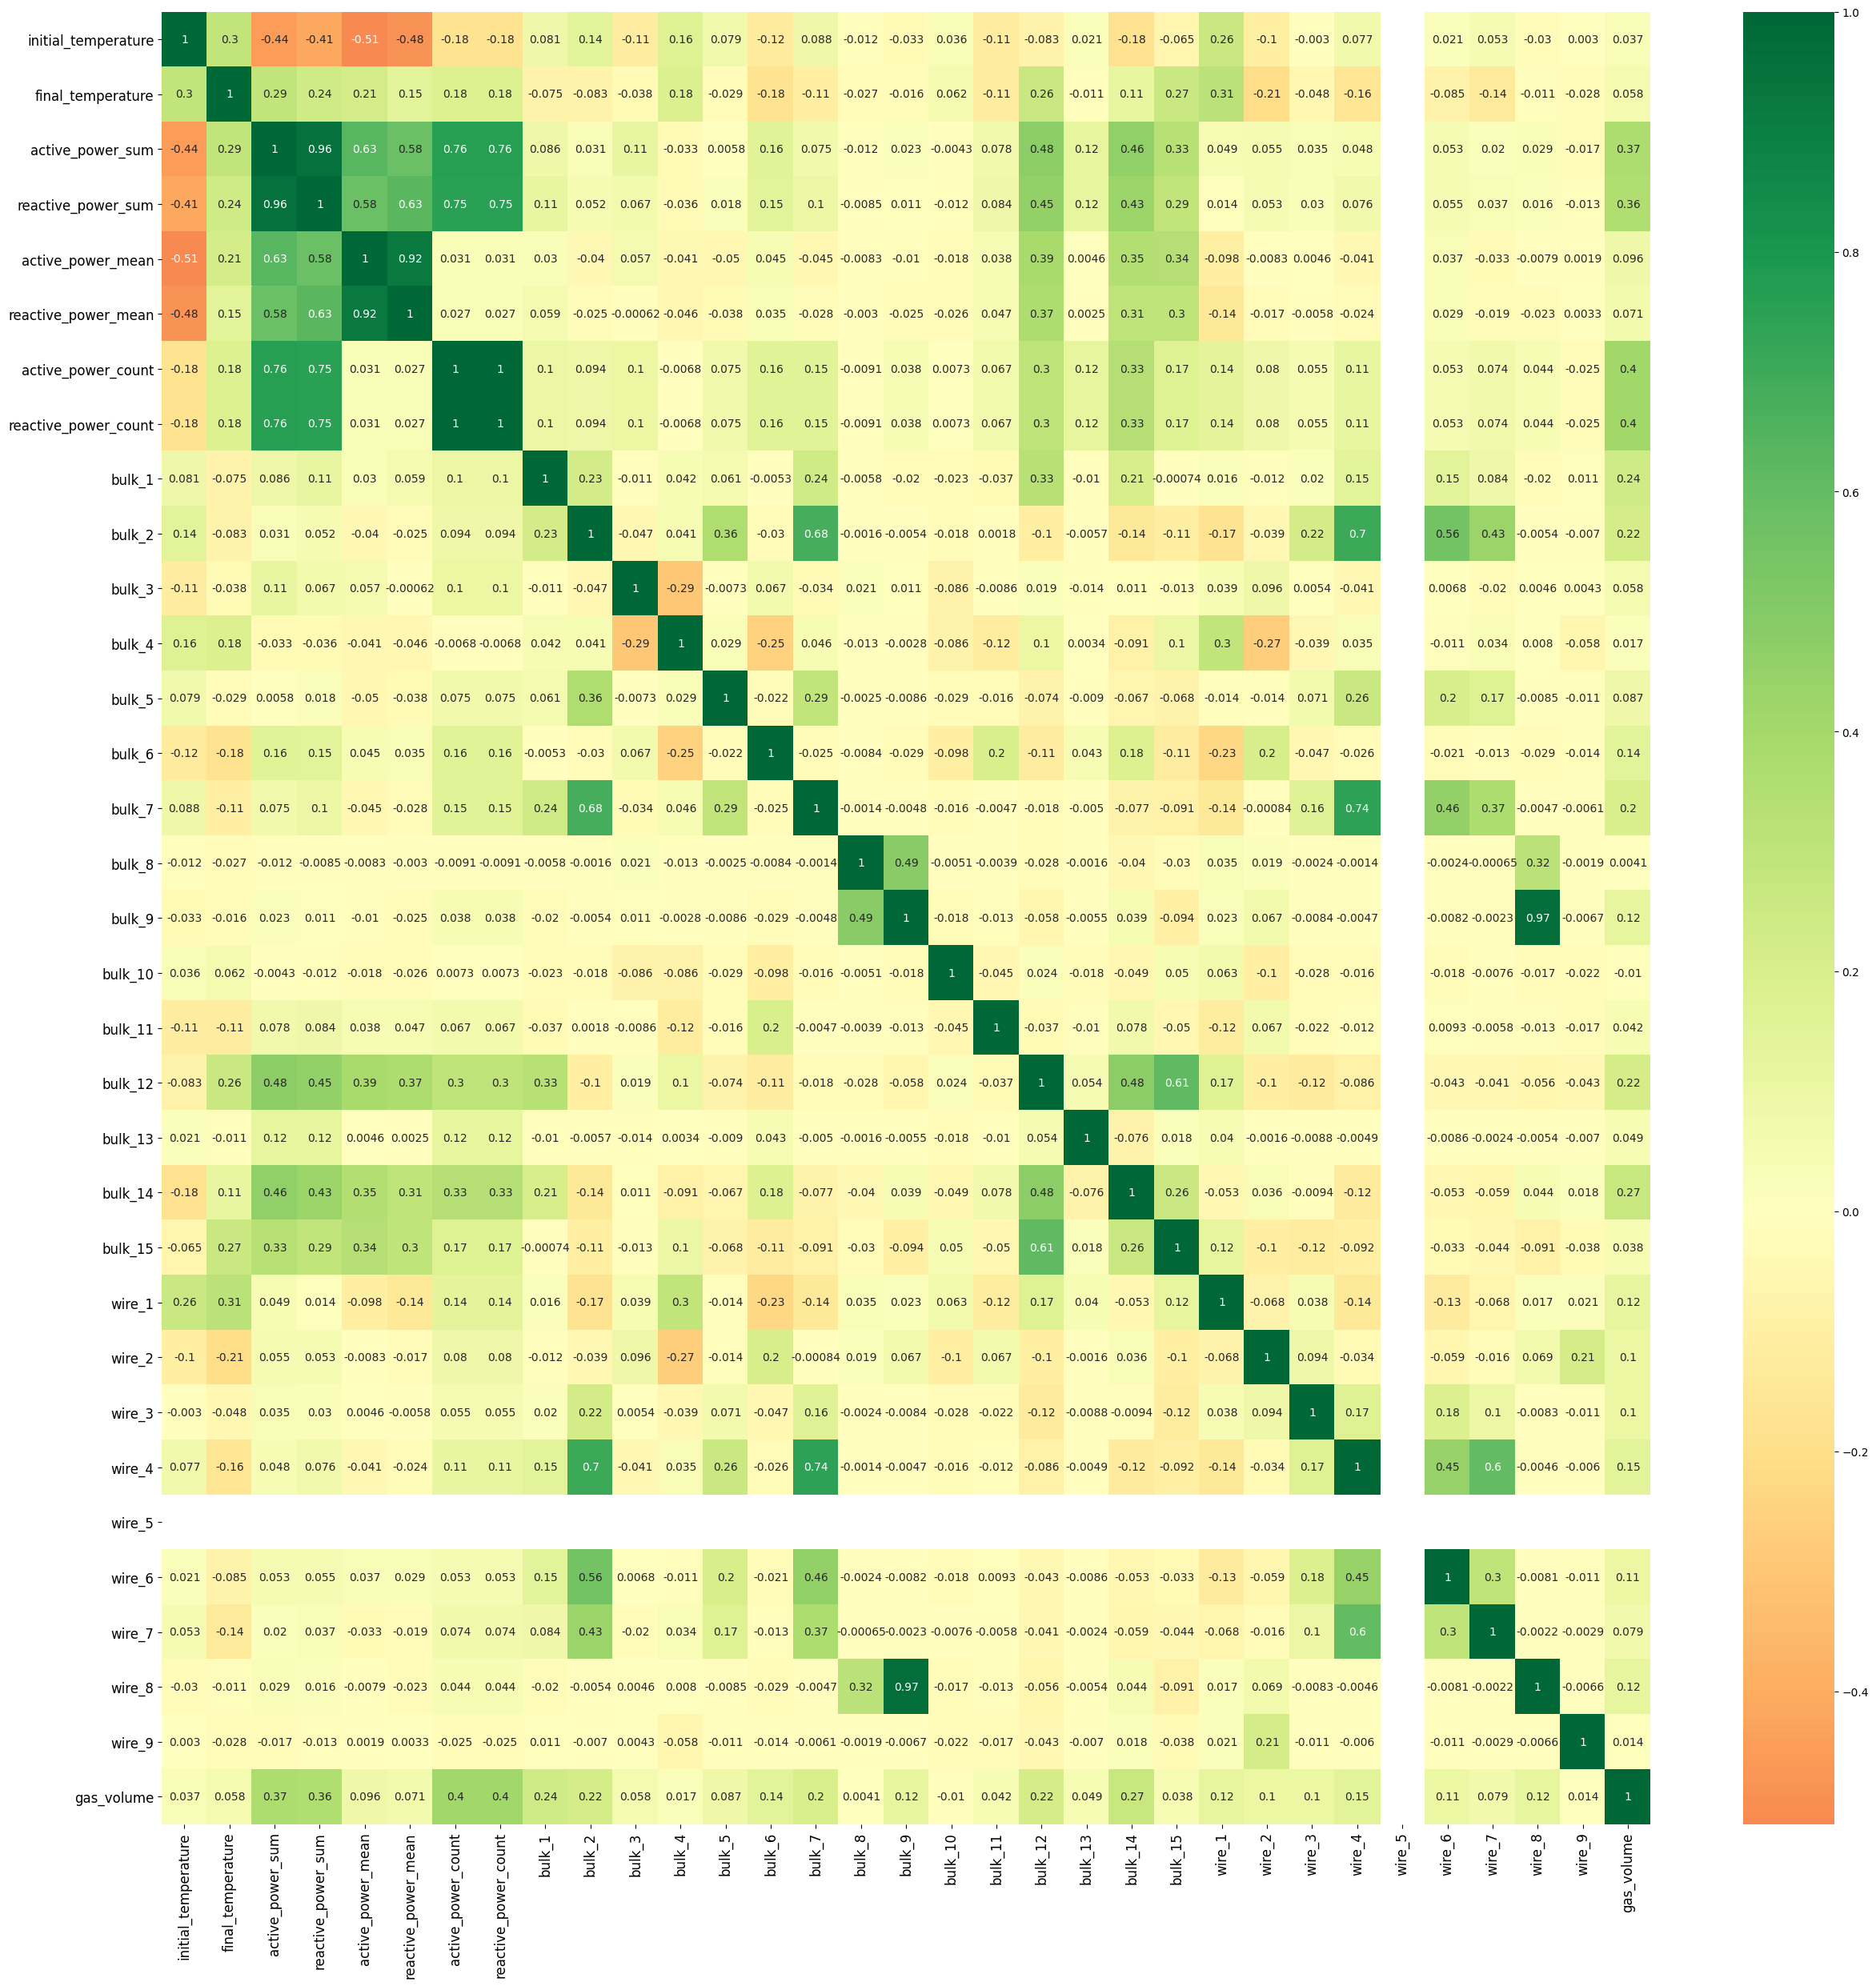

In [282]:
heatmap_plotter(merged_data.drop(['time_diff', 'key'], axis=1), figure_size=(30, 30), dots_per_inch=100)

Lets work with multicollinearity. As we found in the first step of the EDA that there is about 96% correlation between `active_power` and `reactive_power`, it is natural that the correlation between the aggregated data for these columns is high. We will remove the columns relating to `reactive_power` from the dataframe and then take another look at the heatmap.

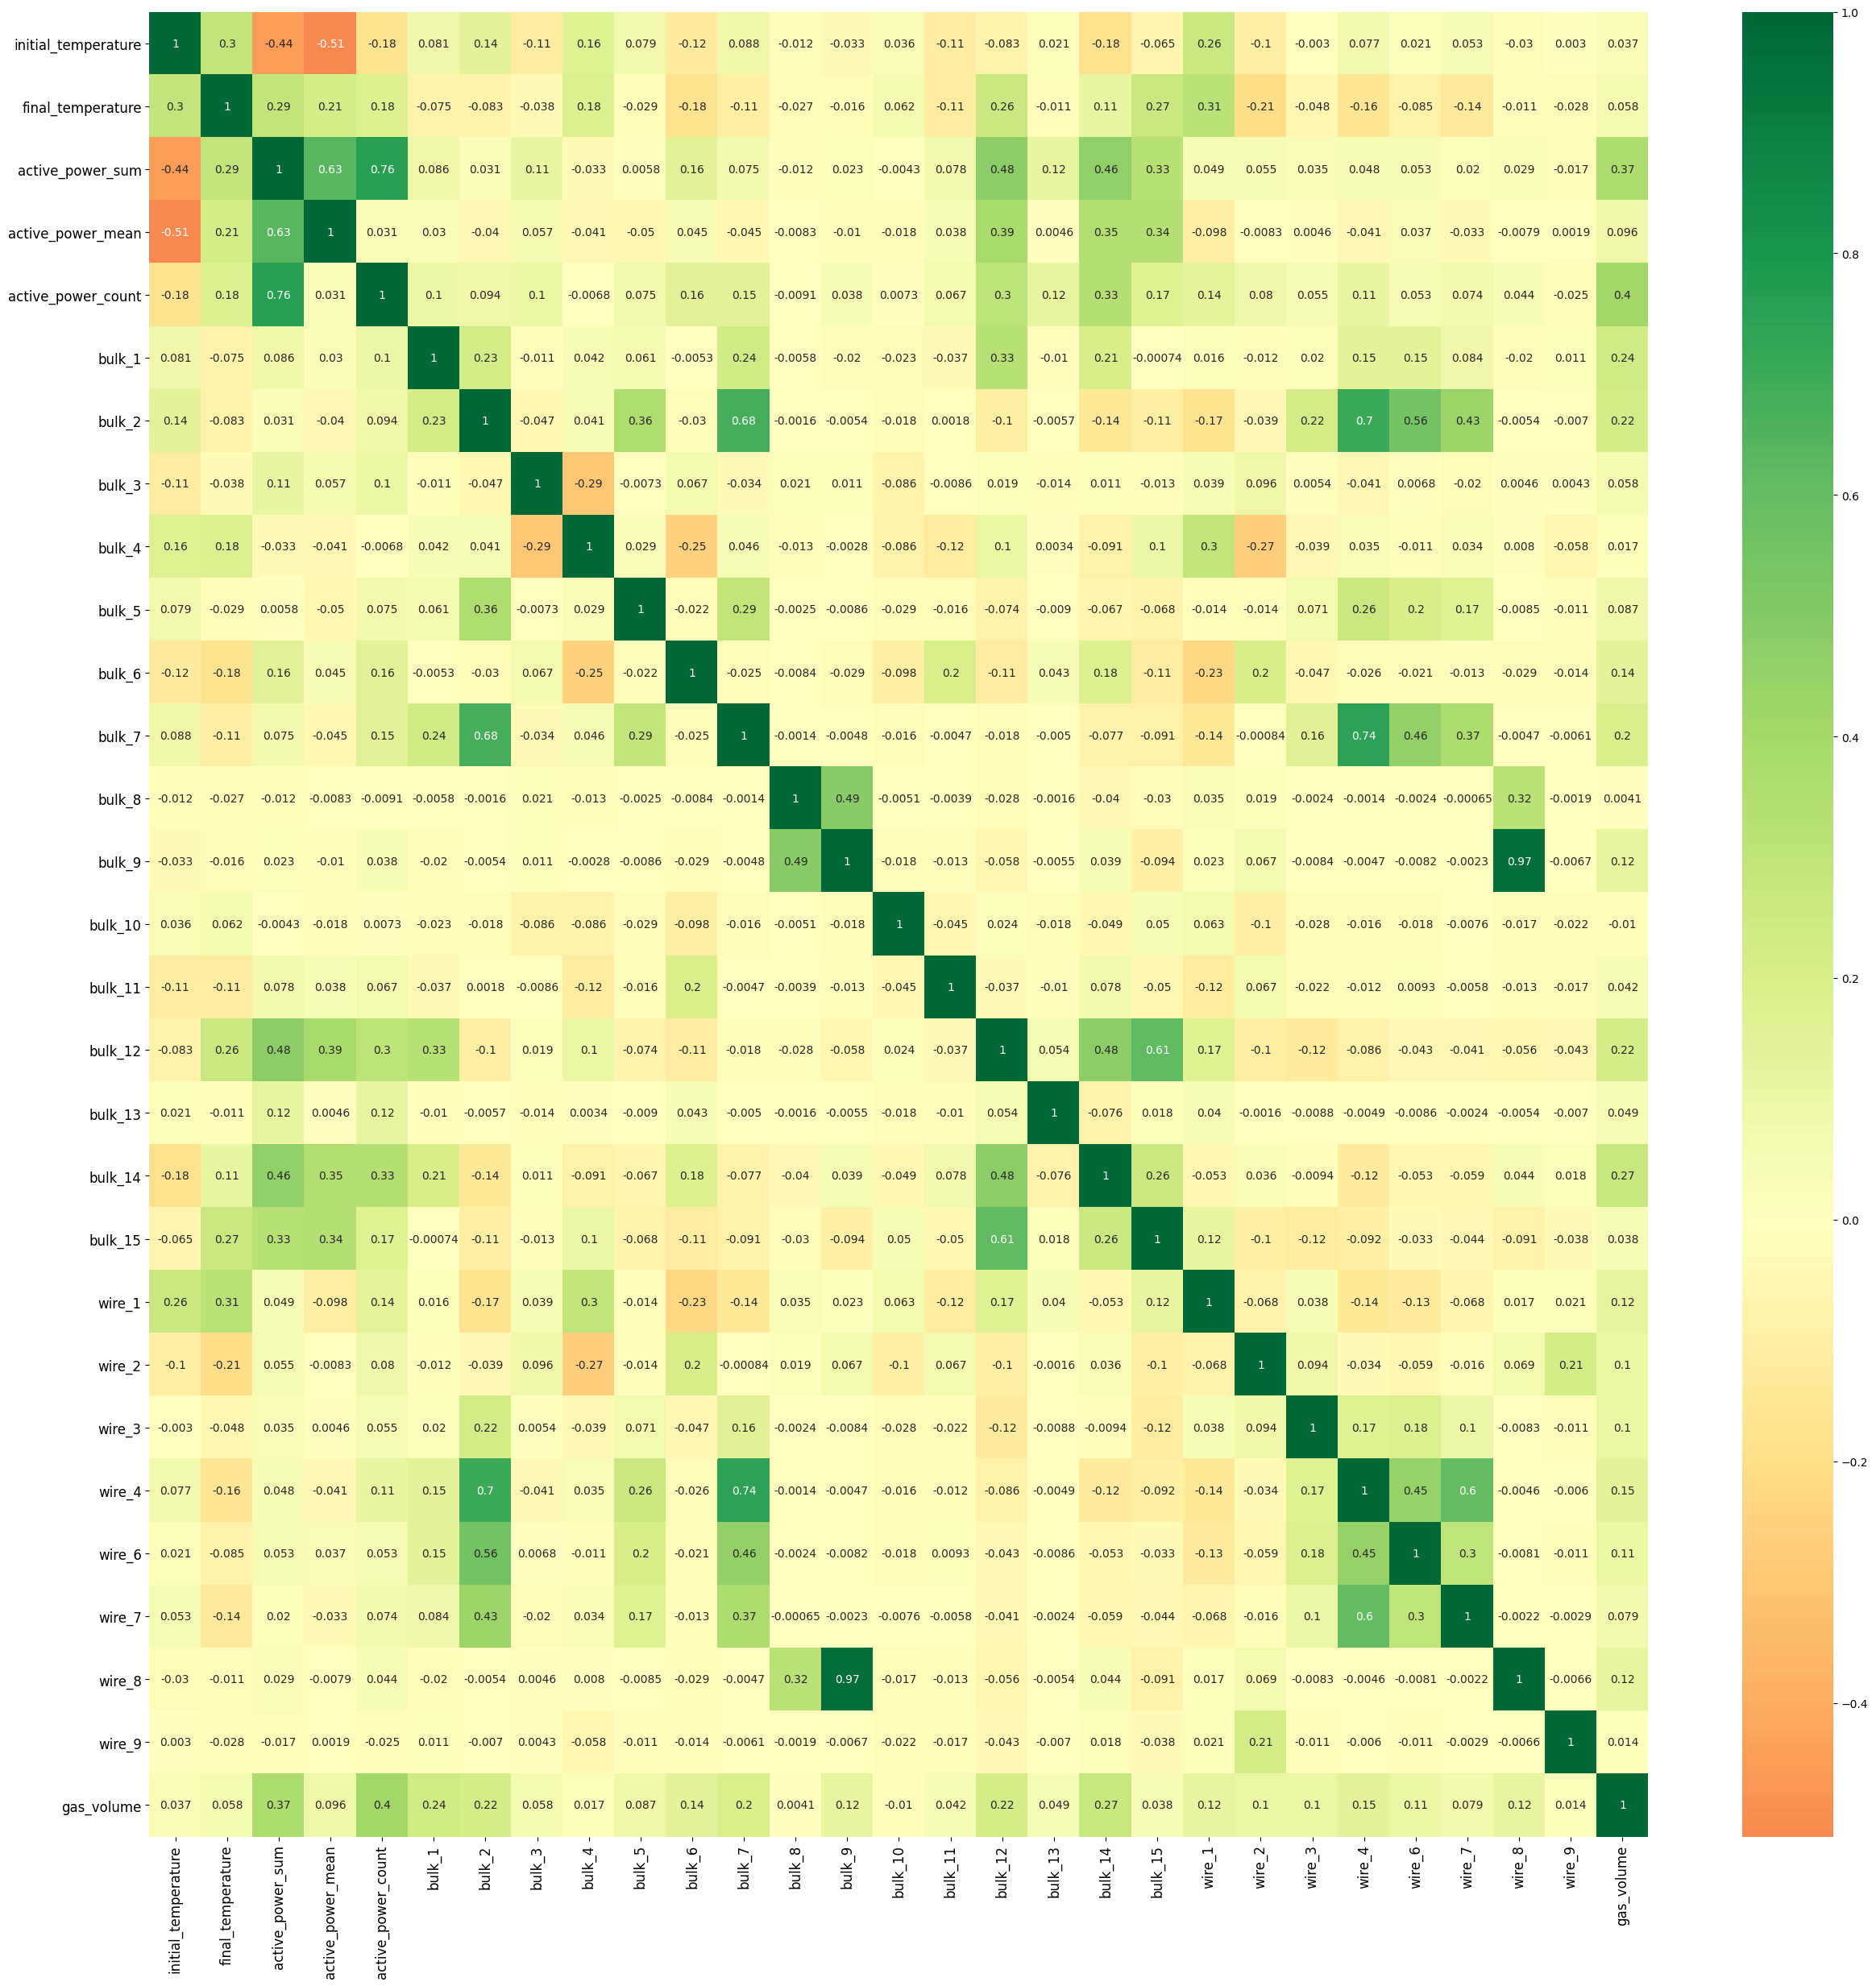

In [283]:
heatmap_plotter(merged_data.drop(['time_diff', 'key', 'reactive_power_sum', 
                                  'reactive_power_mean','reactive_power_count', 'wire_5'], 
                                   axis=1), figure_size=(30, 30), dots_per_inch=100)

It is noticeable that the temperature is inversely related to the active power used. This seems logical, as less energy is needed to heat up to a certain temperature in the ladle where the initial temperature is higher. In some additives, there is a clear tendency to use them together, for example, wire_8 and bulk_9 are almost always used together, while, for example, bulk_3 and bulk_4 are rarely used together. The addition of some additives has a noticeable effect on the increase in temperature and energy input, e.g. bulk_12 and bulk_15. Some additives lower the temperature, for example wire_3. 

It seems reasonable to remove one of the columns in the pair bulk_9 and wire_8 due to their 97% correlation. Delete wire_8 as well as wire_5, for which there are no entries at all in the final data set. 

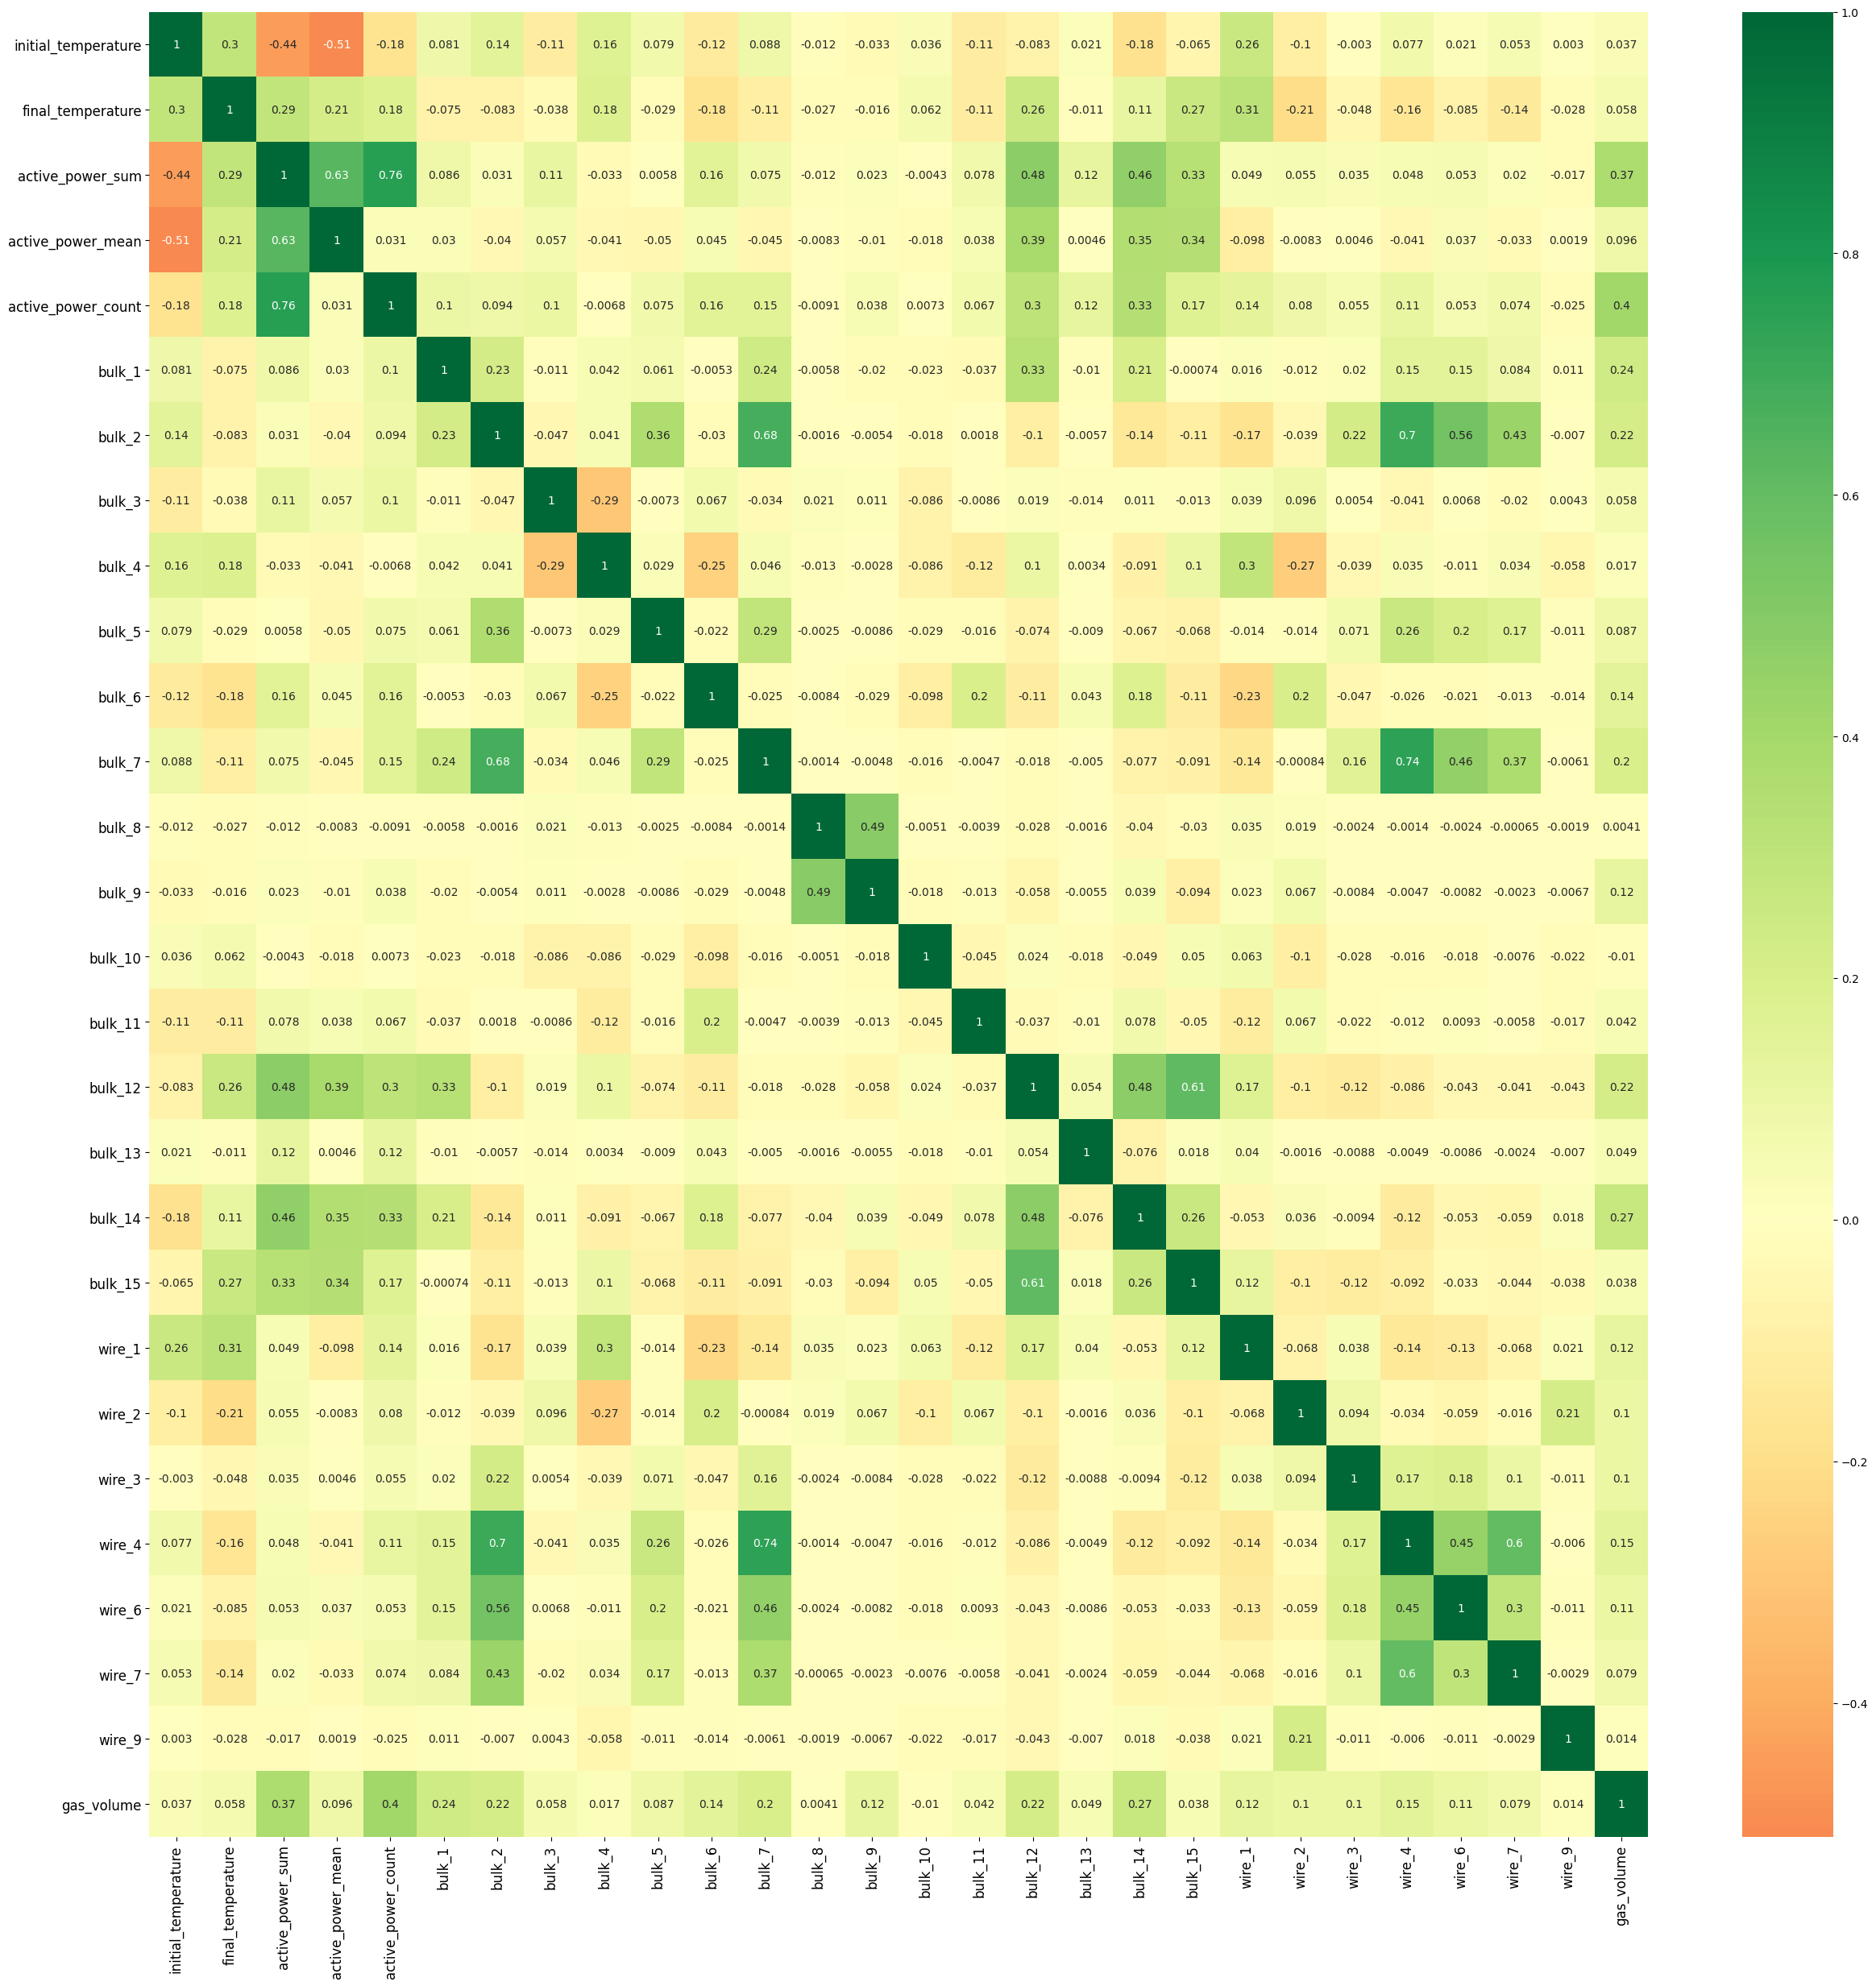

In [284]:
heatmap_plotter(merged_data.drop(['time_diff', 'key', 'reactive_power_sum', 
                                  'reactive_power_mean','reactive_power_count',
                                  'wire_5', 'wire_8'], 
                                   axis=1), figure_size=(30, 30), dots_per_inch=100)

There are no very high correlations left on the heat map. Let's try to train the model on this dataframe.

## Model fitting

Look again at the final dataframe, removing the highly correlated columns as well as the "empty" wire_5.

In [285]:
merged_data = merged_data.drop(labels=['reactive_power_sum', 'reactive_power_mean',
                                       'reactive_power_count', 'wire_5', 'wire_8'], axis=1)

In [286]:
merged_data.head(15)

,key,initial_temperature,final_temperature,time_diff,active_power_sum,active_power_mean,active_power_count,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_9,gas_volume
0,1,1571.0,1613.0,861,4.878147,0.975629,5,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,60.059998,0.000000,0.0,0.0,0.0,0.0,0.0,29.749986
1,2,1581.0,1602.0,1305,3.052598,0.763150,4,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,96.052315,0.000000,0.0,0.0,0.0,0.0,0.0,12.555561
2,3,1596.0,1599.0,1300,2.525882,0.505176,5,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,91.160157,0.000000,0.0,0.0,0.0,0.0,0.0,28.554793
3,4,1601.0,1625.0,388,3.209250,0.802313,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,89.063515,0.000000,0.0,0.0,0.0,0.0,0.0,18.841219
4,5,1576.0,1602.0,762,3.347173,0.836793,4,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,89.238236,9.114560,0.0,0.0,0.0,0.0,0.0,5.413692
5,6,1543.0,1596.0,1385,3.955108,0.988777,4,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,204.0,0.0,201.0,154.0,99.109917,9.114560,0.0,0.0,0.0,0.0,0.0,11.273392
6,7,1586.0,1599.0,1374,2.547375,0.636844,4,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,204.0,0.0,152.0,154.0,98.061600,0.000000,0.0,0.0,0.0,0.0,0.0,9.836267
7,8,1577.0,1598.0,934,3.762755,0.940689,4,0.0,0.0,0.0,99.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,410.0,0.0,252.0,153.0,155.282394,0.000000,0.0,0.0,0.0,0.0,0.0,15.171553
8,9,1587.0,1592.0,1453,2.081951,0.416390,5,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,107.0,0.0,99.0,203.0,113.393279,9.143681,0.0,0.0,0.0,0.0,0.0,8.216623
9,10,1574.0,1593.0,1299,2.923622,0.487270,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,102.0,204.0,81.244796,12.376000,0.0,0.0,0.0,0.0,0.0,6.529891


Let's define the function that will divide the data into training and test samples. Earlier we defined that we will only remove suspicious values from the training sample. After splitting the data into two samples, those records whose `key` column values are in the `suspicious_keys` list will be removed from the test sample. Next, the `key` column will be removed from all samples, since we won't need it for training. The last step of our function is the scaling of numerical features to the training sample. The function will return 4 samples of data: 2 with features, 2 with target features.

In [291]:
def data_processer(df):
    target = df.filter(['key','final_temperature'], axis=1)
    features = df.drop(labels=['final_temperature'], axis=1)
    features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                                train_size=0.80, 
                                                                                random_state=12092022)
    print("Train/Test Sizes: ", features_train.shape, features_test.shape, 
                                        target_train.shape, target_test.shape)
    
    features_train = features_train.query('key not in @suspicious_keys')
    features_train.drop(labels='key', axis=1, inplace=True)
    
    target_train = target_train.query('key not in @suspicious_keys')
    target_train.drop(labels='key', axis=1, inplace=True)
    
    features_test.drop(labels='key', axis=1, inplace=True)
    target_test.drop(labels='key', axis=1, inplace=True)
    
    scaler = StandardScaler()
    scaler.fit(features_train)
    features_train[features_train.columns.to_list()] = scaler.transform(features_train)
    features_test[features_test.columns.to_list()] = scaler.transform(features_test)
    
    return features_train, features_test, target_train, target_test

In [292]:
features_train, features_test, target_train, target_test = data_processer(merged_data)
features_train

Train/Test Sizes:  (1830, 29) (458, 29) (1830, 2) (458, 2)


,initial_temperature,time_diff,active_power_sum,active_power_mean,active_power_count,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_9,gas_volume
2094,-0.420753,0.688255,2.009148,1.588891,0.823121,-0.272844,-0.077435,1.362699,-0.636551,-0.1257,-0.410655,-0.065449,-0.023415,-0.059055,-0.247264,-0.194502,1.354160,-0.072449,0.608247,1.022443,-0.060075,0.637016,-0.119382,-0.06743,-0.11183,-0.026754,-0.088798,0.666331
921,0.376058,-0.666322,-1.076323,-0.574039,-1.060116,-0.272844,-0.077435,-0.632486,-0.636551,-0.1257,0.788373,-0.065449,-0.023415,-0.059055,-0.247264,-0.194502,-0.274676,-0.072449,-0.141610,-0.224069,-0.227485,-0.519430,-0.119382,-0.06743,-0.11183,-0.026754,-0.088798,-0.972633
50,0.082496,0.318368,1.077529,0.507498,0.823121,2.278442,-0.077435,-0.632486,-0.636551,-0.1257,1.123395,-0.065449,-0.023415,-0.059055,-0.247264,-0.194502,1.445375,-0.072449,1.033166,0.987165,-1.437011,-0.519430,-0.119382,-0.06743,-0.11183,-0.026754,-0.088798,-1.630995
1054,0.292183,-0.557284,-1.363936,-2.109529,0.195375,-0.272844,-0.077435,2.736866,-0.636551,-0.1257,-0.410655,-0.065449,-0.023415,-0.059055,-0.247264,-0.194502,-1.356224,-0.072449,-1.903774,-1.423544,0.890158,-0.519430,-0.119382,-0.06743,-0.11183,-0.026754,-0.088798,-1.082432
1979,-0.588502,3.144947,2.385304,0.666338,2.078612,-0.272844,-0.077435,-0.302158,-0.636551,-0.1257,0.488616,-0.065449,-0.023415,-0.059055,-0.247264,-0.194502,0.793841,-0.072449,0.595749,0.575580,-0.033615,-0.519430,-0.119382,-0.06743,0.85170,-0.026754,-0.088798,0.865937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,0.250246,0.450051,0.364448,0.297973,0.195375,-0.272844,-0.077435,3.793918,-0.636551,-0.1257,-0.410655,-0.065449,-0.023415,-0.059055,-0.247264,-0.194502,-0.007547,-0.072449,0.020859,0.410947,-0.155520,-0.519430,-0.119382,-0.06743,-0.11183,-0.026754,-0.088798,3.476232
478,-1.301438,-0.361856,0.053961,-0.680626,0.823121,-0.272844,-0.077435,-0.632486,-0.636551,-0.1257,-0.410655,-0.065449,-0.023415,-0.059055,-0.247264,-0.194502,-0.014062,-0.072449,0.645740,0.387427,-0.271100,0.754621,-0.119382,-0.06743,-0.11183,-0.026754,-0.088798,0.209986
1850,0.459933,0.354434,-0.167154,0.299670,-0.432371,-0.272844,-0.077435,-0.632486,1.151841,-0.1257,-0.410655,-0.065449,-0.023415,-0.059055,-0.247264,-0.194502,0.116244,-0.072449,-0.479046,1.222356,0.894520,-0.519430,-0.119382,-0.06743,-0.11183,-0.026754,-0.088798,-0.457918
1680,1.256743,1.114339,0.117297,-0.046288,0.195375,-0.272844,-0.077435,-0.632486,-0.636551,-0.1257,2.251892,-0.065449,-0.023415,-0.059055,-0.247264,-0.194502,-0.007547,-0.072449,1.195635,0.987165,-0.784671,-0.519430,-0.119382,-0.06743,-0.11183,-0.026754,-0.088798,2.072742


Before we start training the model, let's define a baseline from which we will start analysing the model's result, using the predictions of the `DummyRegressor` model.

In [293]:
dummy = DummyRegressor()
dummy.fit(features_train, target_train)
dummy_prediction = dummy.predict(features_test)
MAE_dummy = mean_absolute_error(target_test, dummy_prediction)
MAE_dummy

8.119339594424835

The Dummy model showed an MAE metric value of about 8.12. We will use this value from now on.

Define a function which will cycle through several models and, depending on the type of model, will perform GridSearch according to the parameter grid passed as argument for each of the models (default parameters are provided). The models will be evaluated according to the MAE metric, which can also be changed when the function is called. The name of the best model, its score and hyperparameters will be returned provided that the metric score is better than our baseline.

In [294]:
def modeller(model, features, target, baseline, 
             lr_param=[{'normalize' : [True, False]}],
             rfr_param=[{'n_estimators': range(1, 100, 10), 
                         'max_depth': range(1, 9, 1), 
                         'min_samples_leaf': range(1, 4), 
                         'min_samples_split': range(2, 4, 2)}],
             knn_param=[{'n_neighbors' : range(3, 100, 2),
                         'weights' : ['distance', 'uniform']}],
             metrics='neg_mean_absolute_error'):
    
    best_score = float('inf')
    best_model = None
    best_params = None
    
    for i in model:
        if type(i) == LinearRegression:
            param_grid_lr=lr_param
            grid = GridSearchCV(i, param_grid=param_grid_lr, scoring=metrics, verbose=4)
            grid.fit(features, target)
            score = grid.score(features, target)
            if abs(score) < best_score:
                best_score = abs(score)
                best_model = i
                best_params = grid.best_params_
        
        elif type(i) == RandomForestRegressor:
            param_grid_rfr=rfr_param
            grid = GridSearchCV(i, param_grid=param_grid_rfr, scoring=metrics, verbose=4)
            grid.fit(features, target)
            score = grid.score(features, target)
            if abs(score) < best_score:
                best_score = abs(score)
                best_model = i
                best_params = grid.best_params_
        
        elif type(i) == KNeighborsRegressor:
            param_grid_knn=knn_param
            grid = GridSearchCV(i, param_grid=param_grid_knn, scoring=metrics, verbose=4)
            grid.fit(features, target)
            score = grid.score(features, target)
            if abs(score) < best_score:
                best_score = abs(score)
                best_model = i
                best_params = grid.best_params_
    
    if best_score > baseline:
        print('None of the models performed better than the DummyRegressor')
    
    else:
        return best_score, best_model, best_params

Create two models, then add them to the `models` list.

In [295]:
rfr = RandomForestRegressor(random_state=12092022)
lr = LinearRegression()
models = [lr, rfr]

Now call the function `modeller`, passing to it the list of models, features and the target feature, as well as the metric of our "Dummy" to check the model for adequacy. The parameter grid and metric will be left untouched.

In [296]:
%%time
#test = modeller(models, features_train, target_train, MAE_dummy)
#test

CPU times: user 7 µs, sys: 1 µs, total: 8 µs
Wall time: 24.8 µs


In [297]:
(4.210199261718854,
 RandomForestRegressor(random_state=12092022),
 {'max_depth': 8,
  'min_samples_leaf': 3,
  'min_samples_split': 2,
  'n_estimators': 91})

(4.210199261718854,
 RandomForestRegressor(random_state=12092022),
 {'max_depth': 8,
  'min_samples_leaf': 3,
  'min_samples_split': 2,
  'n_estimators': 91})

In [298]:
top_model = RandomForestRegressor(max_depth=8, min_samples_leaf=3, min_samples_split=2, 
                                  n_estimators=91, random_state=12092022)

In [299]:
top_model.fit(features_train, target_train)

RandomForestRegressor(max_depth=8, min_samples_leaf=3, n_estimators=91,
                      random_state=12092022)

In [300]:
top_model_prediction = top_model.predict(features_test)

In [301]:
MAE_top_model =  mean_absolute_error(target_test, top_model_prediction)
MAE_top_model

5.686707238990162

We obtained an MAE metric of around 5.69, which meets the customer's requirements (the model should show a metric value of no more than 8.7, and ideally no more than 6) and also exceeds the value of the model we used as a baseline.

Using the `feature_importances_` attribute of an instance of the `RandomForestRegressor` class, obtain an array containing the normalized weights of each of the features. Based on this array, create a dataframe that is sorted in descending order of weights and display the dataframe on the screen.

In [302]:
importances = top_model.feature_importances_
features = features_test.columns.to_list()
importance_df = pd.DataFrame(zip(features, importances), columns=['feature', 'weight'])
importance_df = importance_df.sort_values(by='weight', ascending=False).reset_index(drop=True)
importance_df

,feature,weight
0,initial_temperature,0.264695
1,active_power_sum,0.220387
2,time_diff,0.081696
3,bulk_6,0.078480
4,wire_1,0.070520
5,active_power_mean,0.060584
6,bulk_15,0.042365
7,wire_2,0.034534
8,bulk_7,0.029591
9,bulk_12,0.028915


Let's plot a barchart based on the resulting dataframe to visualise the data. 

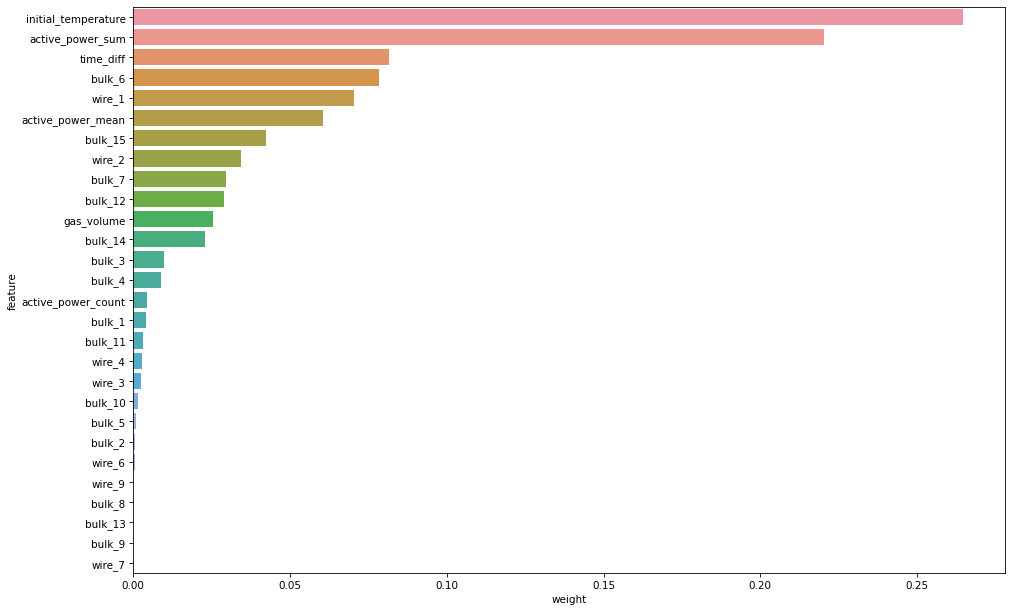

In [303]:
plt.figure(figsize=(15, 10), dpi=75)
sns.barplot(data=importance_df, x='weight', y='feature', orient='h')
None

The maximum influence on the final temperature is the initial temperature in the ladle, with a weight of about 26.4%. The next feature is sum of active energy, with a weight of 22%. It is interesting, that the third important feature is created by our hands - difference between the initial and the final measurement in seconds, its weight is 8.16%, which is approximately equal to the feature bulk_6, after which comes smooth decrease to a feature bulk_14, which weight is 2.28%. Bulk_3 and bulk_4 are the last features that had any significant effect on the model (about 1%). The remaining features in the model seem to be redundant, so we will try to optimize it by removing the relevant columns from the dataframe, for which we create an appropriate filter.

In [304]:
features_filter = importance_df[importance_df['weight'] < 0.008859]['feature'].to_list()  # вес bulk_4
features_filter

['active_power_count',
 'bulk_1',
 'bulk_11',
 'wire_4',
 'wire_3',
 'bulk_10',
 'bulk_5',
 'bulk_2',
 'wire_6',
 'wire_9',
 'bulk_8',
 'bulk_13',
 'bulk_9',
 'wire_7']

Re-train the model on data from which unimportant features have been removed to improve the interpretability of the model.

In [305]:
merged_data_reduced = merged_data.drop(labels=features_filter, axis=1)
merged_data_reduced

,key,initial_temperature,final_temperature,time_diff,active_power_sum,active_power_mean,bulk_3,bulk_4,bulk_6,bulk_7,bulk_12,bulk_14,bulk_15,wire_1,wire_2,gas_volume
0,1,1571.0,1613.0,861,4.878147,0.975629,0.0,43.0,0.0,0.0,206.0,150.0,154.0,60.059998,0.00000,29.749986
1,2,1581.0,1602.0,1305,3.052598,0.763150,0.0,73.0,0.0,0.0,206.0,149.0,154.0,96.052315,0.00000,12.555561
2,3,1596.0,1599.0,1300,2.525882,0.505176,0.0,34.0,0.0,0.0,205.0,152.0,153.0,91.160157,0.00000,28.554793
3,4,1601.0,1625.0,388,3.209250,0.802313,0.0,81.0,0.0,0.0,207.0,153.0,154.0,89.063515,0.00000,18.841219
4,5,1576.0,1602.0,762,3.347173,0.836793,0.0,78.0,0.0,0.0,203.0,151.0,152.0,89.238236,9.11456,5.413692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2283,2495,1570.0,1591.0,1137,3.210690,0.802673,21.0,0.0,0.0,0.0,256.0,129.0,223.0,89.150879,0.00000,7.125735
2284,2496,1554.0,1591.0,1618,4.203064,0.700511,0.0,63.0,0.0,0.0,256.0,129.0,226.0,114.179527,0.00000,9.412616
2285,2497,1571.0,1589.0,717,2.212379,0.737460,0.0,85.0,0.0,0.0,230.0,124.0,226.0,94.086723,9.04800,6.271699
2286,2498,1591.0,1594.0,1302,3.408725,0.681745,90.0,0.0,0.0,0.0,206.0,129.0,207.0,118.110717,0.00000,14.953657


In [306]:
features_train_reduced, features_test_reduced, target_train_reduced, target_test_reduced = data_processer(merged_data_reduced)
features_train_reduced

Train/Test Sizes:  (1830, 15) (458, 15) (1830, 2) (458, 2)


,initial_temperature,time_diff,active_power_sum,active_power_mean,bulk_3,bulk_4,bulk_6,bulk_7,bulk_12,bulk_14,bulk_15,wire_1,wire_2,gas_volume
2094,-0.420753,0.688255,2.009148,1.588891,1.362699,-0.636551,-0.410655,-0.065449,1.354160,0.608247,1.022443,-0.060075,0.637016,0.666331
921,0.376058,-0.666322,-1.076323,-0.574039,-0.632486,-0.636551,0.788373,-0.065449,-0.274676,-0.141610,-0.224069,-0.227485,-0.519430,-0.972633
50,0.082496,0.318368,1.077529,0.507498,-0.632486,-0.636551,1.123395,-0.065449,1.445375,1.033166,0.987165,-1.437011,-0.519430,-1.630995
1054,0.292183,-0.557284,-1.363936,-2.109529,2.736866,-0.636551,-0.410655,-0.065449,-1.356224,-1.903774,-1.423544,0.890158,-0.519430,-1.082432
1979,-0.588502,3.144947,2.385304,0.666338,-0.302158,-0.636551,0.488616,-0.065449,0.793841,0.595749,0.575580,-0.033615,-0.519430,0.865937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,0.250246,0.450051,0.364448,0.297973,3.793918,-0.636551,-0.410655,-0.065449,-0.007547,0.020859,0.410947,-0.155520,-0.519430,3.476232
478,-1.301438,-0.361856,0.053961,-0.680626,-0.632486,-0.636551,-0.410655,-0.065449,-0.014062,0.645740,0.387427,-0.271100,0.754621,0.209986
1850,0.459933,0.354434,-0.167154,0.299670,-0.632486,1.151841,-0.410655,-0.065449,0.116244,-0.479046,1.222356,0.894520,-0.519430,-0.457918
1680,1.256743,1.114339,0.117297,-0.046288,-0.632486,-0.636551,2.251892,-0.065449,-0.007547,1.195635,0.987165,-0.784671,-0.519430,2.072742


In [118]:
%%time
#test = modeller(models, features_train, target_train, MAE_dummy)
#test

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.81 µs


In [307]:
(4.2265748190835,
 RandomForestRegressor(random_state=12092022),
 {'max_depth': 8,
  'min_samples_leaf': 3,
  'min_samples_split': 2,
  'n_estimators': 91})

(4.2265748190835,
 RandomForestRegressor(random_state=12092022),
 {'max_depth': 8,
  'min_samples_leaf': 3,
  'min_samples_split': 2,
  'n_estimators': 91})

In [308]:
top_model_reduced = RandomForestRegressor(random_state=12092022, max_depth=8, 
                                  min_samples_leaf=3, min_samples_split=2,
                                  n_estimators=91)

In [309]:
top_model_reduced.fit(features_train_reduced, target_train_reduced)

RandomForestRegressor(max_depth=8, min_samples_leaf=3, n_estimators=91,
                      random_state=12092022)

In [310]:
top_model_reduced_prediction = top_model_reduced.predict(features_test_reduced)

In [311]:
MAE_top_model_reduced =  mean_absolute_error(target_test_reduced, top_model_reduced_prediction)
MAE_top_model_reduced

5.693224963683407

The metric has not improved, it has remained about the same, but there are fewer features in the model, making it more interpretable and understandable for customer representatives. Let us highlight the top features that have the most impact on the model.

In [312]:
importances_reduced = top_model_reduced.feature_importances_
features = features_test_reduced.columns.to_list()
importances_reduced_df = pd.DataFrame(zip(features, importances), columns=['feature', 'weight'])
importances_reduced_df = importances_reduced_df.sort_values(by='weight', 
                                                            ascending=False).reset_index(drop=True)
importances_reduced_df

,feature,weight
0,initial_temperature,0.264695
1,active_power_sum,0.220387
2,time_diff,0.081696
3,bulk_15,0.078480
4,active_power_mean,0.060584
5,wire_1,0.029591
6,bulk_7,0.009847
7,bulk_12,0.008859
8,bulk_3,0.004365
9,bulk_4,0.004309


In [313]:
importances_reduced_top5 = importances_reduced_df.head()
importances_reduced_top5

,feature,weight
0,initial_temperature,0.264695
1,active_power_sum,0.220387
2,time_diff,0.081696
3,bulk_15,0.078480
4,active_power_mean,0.060584


In [314]:
importances_reduced_top5['weight'].sum()

0.7058431854693723

## Conclusion on the results

In this work we have done extensive data processing, including examining the main statistics for each dataframe, visualising the data, dealing with duplicates and missing values, identifying outliers and suspicious values, and inspecting correlations. 

For the two dataframes, we also worked on creating new dataframes based on the original dataframes: we aggregated the data from data_arc on a "one line-one ladle" basis using several aggregation functions; from data_temp, we generated the dataframe containing the ladle number, the initial and final temperatures, and the number of seconds between the first and last temperature measurements. 

We then merged all the dataframes together. We checked the final dataframe for gaps and also looked at correlations. Some of the features were removed after analysis for multicollinearity and also due to the low number of records. 

We then proceeded to create a training sample and a test sample, removing suspect records from the training sample. The last preparatory step was to scale the numerical data.

We used GridSearchCV and two models, linear regression and random forest, to determine the best model. When selecting the model and hyperparameters, we immediately performed the model adequacy test on the target metric.

The best model turned out to be a random forest, which showed a MAE metric value of about 5.69 on the test sample. Having analysed the weights of the features in the model, we found a number of features that had no significant effect on the performance of the model. These features were removed from the dataframe and the model was fitted and trained again. 

The MAE score of the final model on the test sample was slightly worse than that of the previous model, but the model is more interpretable because of the smaller number of features. 

The features that have the greatest impact on the final model are:
- initial_temperature,
- active_power_sum,
- time_diff,
- bulk_15,
- active_power_mean.

The contribution of these features is 70.6%. 

Features to which you can pay less attention are:
- active_power_count, 
- bulk_1,
- bulk_2,
- bulk_5, 
- bulk_11,
- bulk_8,
- bulk_9,
- bulk_10,
- bulk_13,
- wire_3, 
- wire_4, 
- wire_5, 
- wire_6, 
- wire_7, 
- wire_8 
- wire_9.

## Report

# A regression model for predicting steel temperature
<p class="lead">In this section, a detailed report is given, based on the results of work with data obtained from the customer, a steel mill. The main objective of the work <b>is to build a model for predicting the steel temperature.</b></p> 

<p class="lead">We were provided with five datasets containing information on electric arc heating, additives (in terms of amount of additives), metal gas purging, and molten metal temperature measurements in the ladles.

<p class="lead"><b>First stage: Data preparation</b>
<p class="lead">In order to achieve the objective, the first tasks to be performed were primary data processing and examination, dealing with outliers and suspicious values, including outliers.</p>

<p class="lead">During the data preparation phase, we found that there were some values in the data that were statistically significantly different from the rest of the data. These values were most commonly found in the datasets relating to additives. In order to ensure that the model could handle such values correctly, we marked the data by flagging the brightest statistical outliers as suspicious values. Examples of such values can be seen in the graph below concerning wire additives (such values look like single dots).</p>

| Examples of suspicious values on the data_wire dataset |
|-|
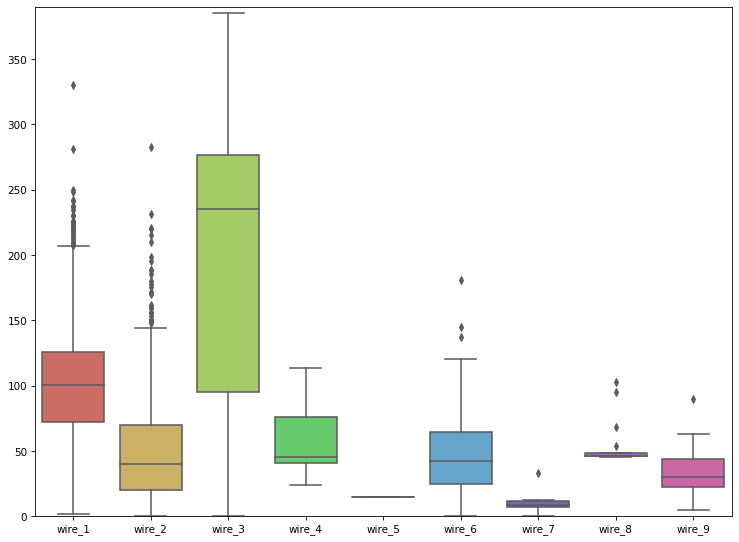

<p class="lead">Information about ladles, which contain such suspicious values, was not subsequently used for training the model, but was used in its testing. If there is evidence that the specified values are correct and due to the technical process, these values can be returned to the dataset on which the model is trained.</p>
<p class="lead">For some data, there were values that could not be explained physically, e.g. a negative reactive power value, or a fixation of the steel temperature in the ladle much lower than its melting point. Such values were marked as outliers and were removed both from the data set on which the model was trained and from the data set for its testing. Examples of such values are given below.</p>

| Examples of outliers on the data_temp dataset |
|-|
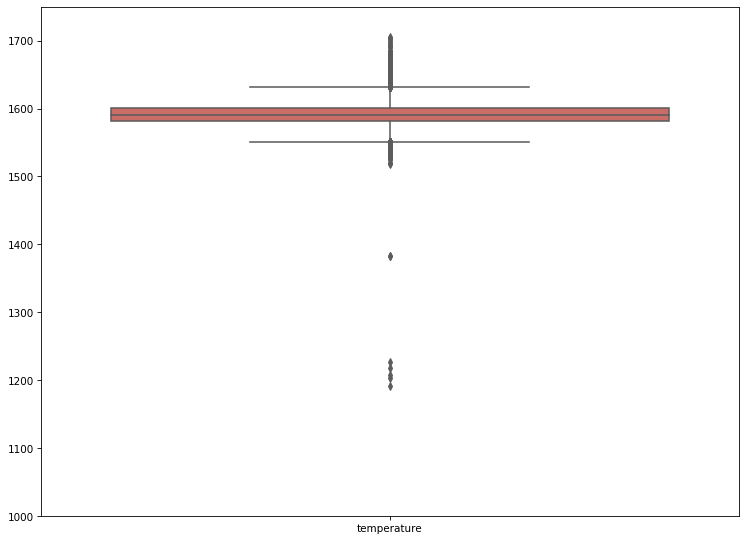

<p class="lead">As part of the preparatory phase, additional features were also created, some of which played an important role in the modelling. For example, we added active and reactive power information to the dataset in an aggregated form for each of the ladles, in particular their total number, the average value, and the number of heating iterations.</p>
<p class="lead">We did not use any specialised algorithms to fill in the gaps when dealing with them. In the datasets that dealt with additives, the missing values were filled with zeros, as the missing values obviously indicated that the relevant additive was not being used within the ladle. Since the task at hand concerns the prediction of the final ladle temperature, it was important for us to weed out all those ladles that contained omissions in the column with the temperature in the chronologically latest iteration. Given the fact that the initial temperature is also an important feature, we also eliminated those ladles that contained gaps in the chronologically first iteration. If there were fewer than two heating iterations, or if the initial and final temperatures were equal, we removed such entries from the dataset, as in this case the model would have received information about the target feature it should predict (a so-called 'target feature leak'). One of the last steps in this step was to merge all the data into one set. The basis for merging was a data set that contained the ladle number, the initial and final temperatures, and the difference in seconds between the first and last measurement.
<p class="lead">We ended up with a table containing 2,288 entries. This table was subjected to a correlation search, in which part of the columns were removed due to a very high correlation of their values with other columns (the so-called "multicollinearity"). Some columns were also removed because of a very low number of entries.</p>
<p class="lead">Below is a summary heatmap of the correlations, showing the columns where the increase in values is accompanied by an increase in values in the other column (green on the map), or a decrease in values in the other column (red on the map). The lack of correlation between the two attributes is indicated by the yellow colour on the map. An example of high positive correlation is the additions bulk_7 and wire_4 - their correlation is 0.74. An example of a negative correlation is the initial temperature and the average amount of power used - their correlation is -0.51, indicating higher power consumption on average in cases where the initial temperature was low.</p>

| The final correlation heatmap |
|-|
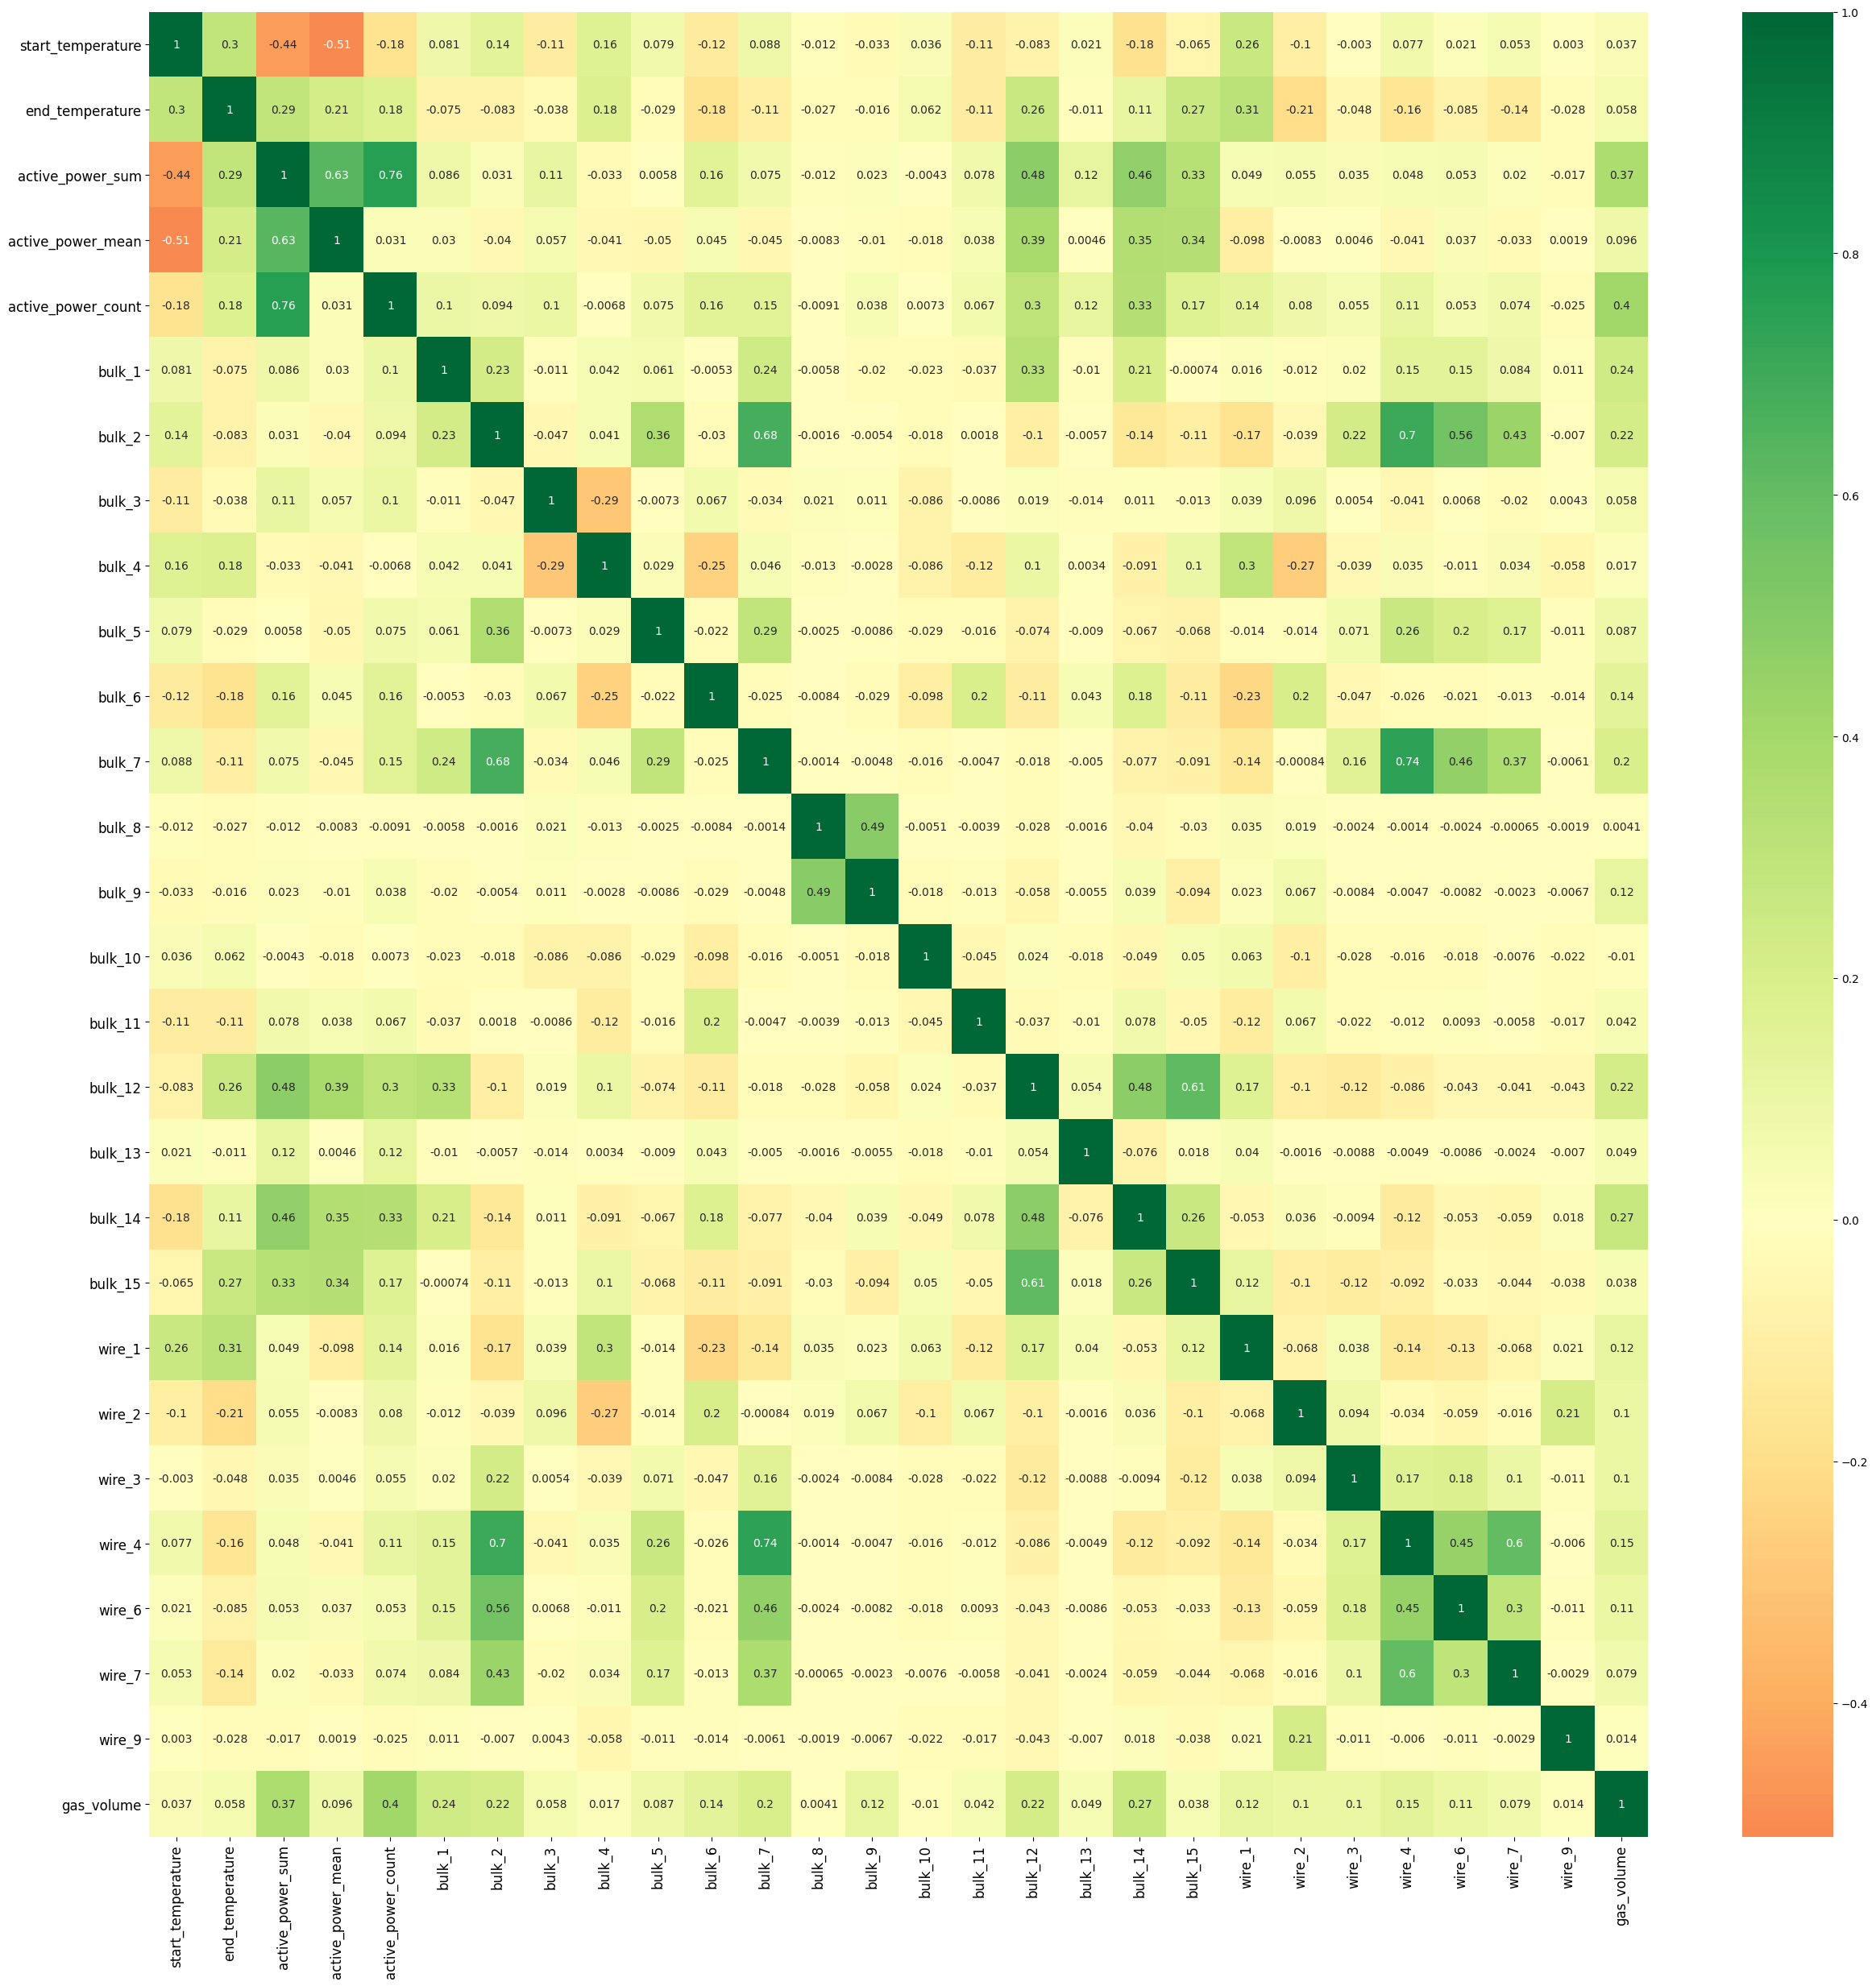

<p class="lead"><b>Second stage: Choosing a model</b>
<p class="lead">Before selecting the model, we divided the data set into two parts: a training sample and a test sample. In the training sample, the ladles containing suspicious values were removed. The work was also done to bring the data to the same scale: so that the mean of the observed values was 0 and the standard deviation was 1.</p>
<p class="lead">The metric used is the 'mean absolute error', the average of the absolute differences between the target value and the value predicted by the model on a given training sample. Before fitting the model, we defined a 'baseline' - a metric threshold below which the model can be considered more useful than predicting for any input data the mean value over the training sample. The specified metric on a model that always predicts the mean from the training dataset was 8.12.
<p class="lead">The selection of models and their settings (so called "hyperparameters") was performed using the "GreedSearchCV" method, which searches all possible variants of model hyperparameters from those that have been passed to the algorithm for processing. On each set of hyperparameters a metric is calculated and the hyperparameters of the model with the best metric are stored for future use.</p>
<p class="lead">To find the best model, we used two types of models - Logistic Regression, and the Random Forest algorithm. The best metric was demonstrated by the Random Forest algorithm, a so-called ensemble model consisting of several simpler models - Decision Trees (in our case we used 91 Decision Trees), whose predictions are averaged, which makes this type of model insensitive to outliers. In general, the Random Forest algorithm has fairly high prediction accuracy compared to many other models.
<p class="lead">The best model metric on the test data was 5.69, which is significantly lower than the baseline. Having analysed the model, we identified those features that had the greatest impact on the model's predictions.

| Bar chart of the importance of the features |
|-|
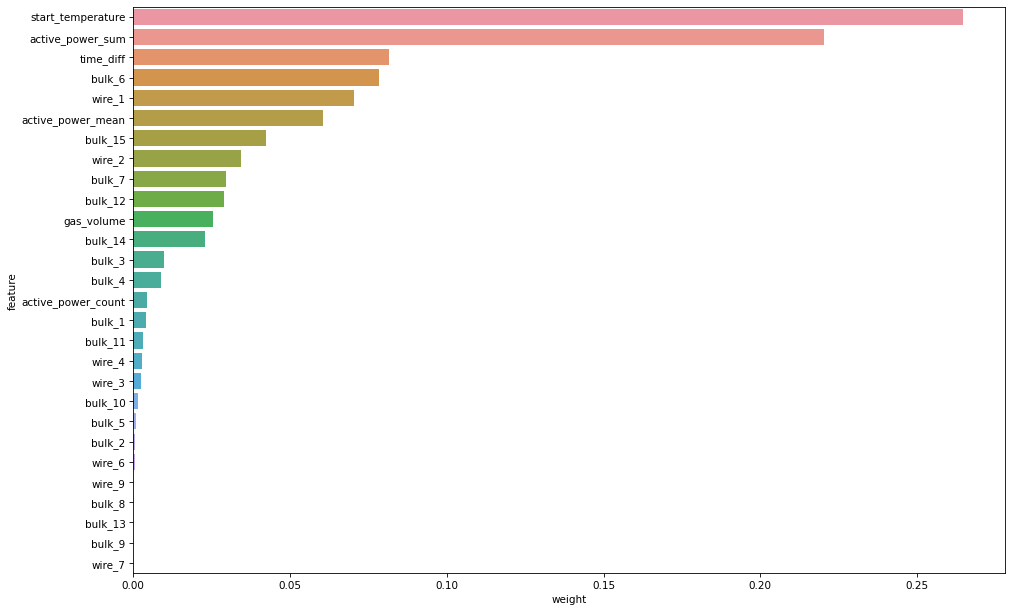

<p class="lead">This diagram shows that about half of the features in our model are minimal, so it would be possible to exclude them from the training, which would simplify the model and make it more interpretable. 
<p class="lead">Given the above conclusion, we trained another Random Forest model on data in which columns with features that have a low impact on model predictions were removed. The metric for this model is almost identical to the model trained on the full dataset, but the model with fewer features is preferable because it is easier to interpret.
<p class="lead">The features that have the greatest influence on the final model are the initial temperature, the total amount of active energy, the time difference between the first and last temperature measurement, the amount of bulk_15, and the average amount of active energy. The contribution of these features to the model prediction is 70.5%.
<p class="lead">Understanding which features have the greatest influence on the model allows for a more conscious approach to the management of the target feature - the final steel temperature.